# Astrofísica Computacional

Se desarrollará en el siguiente notebook los pasos correspondientes del tutorial de Trazado Inverso de Rayos

In [2]:
import os
path = 'C:/Users/osole/OneDrive/Documentos/1_Astro/2/AC'
os.chdir(path)

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'inferno'

%matplotlib inline

## Creación de la clase
Se crea una clase que contendrá todos los métodos necesarios para el desarrollo del tutorial. Desde la generación de fuentes hasta la implementación de lentes binarias dobles. Cada método tendrá asociadas funcionalidades de representación de resultados de manera que el usuario, sin conocer la estructura interna de las funciones, pueda editar parámetros fácilmente y ver las diferencias en el resultado.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class LG:
    def __init__(self, nx = 1001, ny = 388, xl = 8, yl = 8):
        self.nx = nx  # num de pix en la imagen
        self.ny = ny  # num de pix en la fuente
        self.xl = xl  # tamaño físico del lado de la imagen
        self.yl = yl  # tamaño físico del lado de la fuente
        self.xs=2*self.xl/(self.nx-1)  # tamaño pix en la imagen
        self.ys=2*self.yl/(self.ny-1)  # tamaño pix en la fuente
        self.im_rgb = False
        
    def source(self, value, 
               square = False, n_side=5,
               circle = False, r=10, x_c=0, y_c=0,
               rings = False, n_r = 4, w_r = 3):
        self.value = value
        self.src_matrix = np.zeros([self.ny, self.ny])
        #self.x, self.y = np.mgrid[0:self.ny, 0:self.ny]
        self.rad = self.ny//2
        self.x, self.y = np.arange(0,self.ny), np.arange(0,self.ny)
        

        if square == True:
            self.n_side = n_side
            self.x_in1 = self.rad - n_side//2 < self.x
            self.x_in2 = self.x < self.rad + n_side//2
            self.x_in = self.x_in1*self.x_in2
            self.y_in1 = self.rad - n_side//2 < self.y
            self.y_in2 = self.y < self.rad + n_side//2
            self.y_in = self.y_in1*self.y_in2
            self.src_typ = 'Square'
            
            for i in range(self.ny):
                for j in range(self.ny):
                    if self.y_in[j]==True and self.x_in[i]==True:
                        self.src_matrix[i,j] = self.value
        
        if circle == True:
            self.r = r
            x, y = np.mgrid[0:self.ny, 0:self.ny]
            self.rads = (x-x_c-self.ny/2)**2 + (y-y_c-self.ny/2)**2
            self.src_typ = 'Circle'
            
            for i in range(self.ny):
                for j in range(self.ny):
                    if self.rads[i][j]<=self.r**2:
                        self.src_matrix[i,j] = self.value
        
        if rings == True:
            self.r = r
            self.n_r = n_r
            self.w_r = w_r
            x, y = np.mgrid[0:self.ny, 0:self.ny]
            self.rads = (x-x_c-self.ny/2)**2 + (y-y_c-self.ny/2)**2
            self.src_typ = 'Rings'

            for i in range(self.ny):
                for j in range(self.ny):
                    for k in range(self.n_r):                        
                        if self.rads[i][j]<=(self.r-k*self.w_r)**2:
                            self.src_matrix[i,j] = self.value*(k+1)/self.n_r

#  -------------------------------  Transformación  -------------------------------
    def transf(self, ploteo = False, identidad = False,
              puntual = False, ml = 0, x0 = (0,0),
              cuadru = False, gam = 0, kap = 0,
              SIS = False,
              cuadru_SIS = False,
              binary = False, x02 = (0,0), eps1=0.5, eps2=0.5,
              mag_map = False):
        self.gam = gam
        self.x0 = x0
        self.ml = ml
        self.i = np.zeros((self.nx, self.nx)) #imagen
        if self.im_rgb == True:
            self.i = np.zeros((self.nx, self.nx,3), dtype = int) #imagen
        f = self.src_matrix #fuente
        #fijar lente:
        if identidad == True:
            self.lens_typ = 'Identity'
            def alfa(x_1, x_2):
                return 0,0
        if puntual == True:
            self.lens_typ = 'Point source'
            def alfa(x_1, x_2):
                d2 = (x_1-x0[0])**2 + (x_2-x0[1])**2 + 1E-12
                return ml*(x_1-x0[0])/d2, ml*(x_2-x0[1])/d2
        if cuadru == True:
            self.lens_typ = 'Cuadrupolar'
            def alfa(x_1,x_2):
                d2 = (x_1-x0[0])**2 + (x_2-x0[1])**2 + 1E-12
                return x_1*(gam + kap) + ml*(x_1-x0[0])/d2, x_2*(-gam+kap) + ml*(x_2-x0[1])/d2
        if SIS == True:
            self.lens_typ = 'Singular Isothermal Sphere'
            def alfa(x_1,x_2):
                d = np.sqrt((x_1-x0[0])**2 + (x_2-x0[1])**2 + 1E-12)
                return ml*(x_1-x0[0])/d, ml*(x_2-x0[1])/d
        if cuadru_SIS == True:
            self.lens_typ = 'Cuadrupolar + SIS'
            def alfa(x_1,x_2):
                d = np.sqrt((x_1-x0[0])**2 + (x_2-x0[1])**2 + 1E-12)
                return x_1*(gam + kap) + ml*(x_1-x0[0])/d, x_2*(-gam+kap) + ml*(x_2-x0[1])/d
        if binary == True:
            self.lens_typ = 'Binary'
            def alfa(x_1, x_2):
                d21 = (x_1-x0[0])**2 + (x_2-x0[1])**2 + 1E-12
                d22 = (x_1-x02[0])**2 + (x_2-x02[1])**2 + 1E-12
                return eps1*(x_1-x0[0])/d21+eps2*(x_1-x02[0])/d22, eps1*(x_2-x0[1])/d21+eps2*(x_2-x02[1])/d22
        # mapa de magnificación
        if mag_map == True:
            self.A = np.zeros((self.ny,self.ny), dtype = int) #matriz de ceros con dim de la fuente
        # recorrer imagen
        for j1 in range(0, self.nx-1):
          for j2 in range(0, self.nx-1):
            # transf de pix de imagen a coord
            x1 = -self.xl+(j1-1)*self.xs
            x2 = -self.xl+(j2-1)*self.xs
            a1, a2 = alfa(x1, x2)
            # Transf inversa
            y1 = x1 - a1
            y2 = x2 - a2
            # Transf coordenadas en el plano de la fuente a pix
            i1=int((y1+self.yl)/self.ys+1)
            i2=int((y2+self.yl)/self.ys+1)
            if ((i1>=0)&(i1<=self.ny-1)&(i2>=0)&(i2<=self.ny-1)):
                if self.im_rgb == False:
                    self.i[j1,j2]=f[i1,i2]
                    if mag_map == True:
                        self.A[i1,i2]=self.A[i1,i2]+1
                if self.im_rgb == True:
                    for k in range(3):
                        self.i[j1,j2,k]= int(f[i1,i2,k])
            else:
                if self.im_rgb == False:
                    self.i[j1,j2]=0
                if self.im_rgb == True:
                    for k in range(3):
                        self.i[j1,j2,k]=0
        if ploteo == True:
            if mag_map == False:
                fig, ax = plt.subplots(1,2, figsize = (12,8))
                ax[1].imshow(self.i, extent = (-self.xl,self.xl, -self.xl,self.xl))
                ax[1].set_title('Image')
            if mag_map == True:
                fig, ax = plt.subplots(1,3, figsize = (14,6))
                ax[1].imshow(self.A, extent = (-self.yl,self.yl, -self.yl,self.yl))
                ax[2].imshow(self.i, extent = (-self.xl,self.xl, -self.xl,self.xl))
                ax[1].plot(0,0, 'x', color='red')
                ax[1].set_title('Magnification map')
                ax[2].set_title('Image')
            ax[0].imshow(self.src_matrix, extent = (-self.yl,self.yl, -self.yl,self.yl))
            ax[0].set_title('Source type: %s'%self.src_typ)
            plt.suptitle('Lens type: %s\nPosition x=(%.1f,%.1f)\n$m_l=%.2f,\ \\gamma=%.2f$'%(self.lens_typ,x0[1],x0[0], ml, gam))


#  -------------------------------  Fuente imagen  -------------------------------
    def source_img(self, image):
        self.im_rgb = True
        self.src_typ = 'Image'
        self.nx = image.shape[0]  # num de pix en la imagen
        self.ny = image.shape[0]  # num de pix en la fuente
        self.xl = 1  # tamaño físico del lado de la imagen
        self.yl = 1  # tamaño físico del lado de la fuente
        self.xs=2*self.xl/(self.nx-1)  # tamaño pix en la imagen
        self.ys=2*self.yl/(self.ny-1)  # tamaño pix en la fuente

        self.src_matrix = image
        #self.src_matrix_g = image[:,:,1]
        #self.src_matrix_b = image[:,:,2]


#  -------------------------------  Cortes en mapa de magnificación  -------------------------------
    def map_cuts(self, horiz = False, nrow = 0, vert = False, ncol = 0, ploteo = False):
        if horiz == True:
            if nrow == 0:
                nrow = self.A.shape[0]//2
            self.cut = self.A[nrow,:]
            self.cut_s = ['Horizontal', 'row']
            n = nrow
        if vert == True:
            if ncol == 0:
                ncol = self.A.shape[0]//2
            self.cut = self.A[:,ncol]
            self.cut_s = ['Vertical', 'column']
            n = ncol
        if ploteo == True:
            x_cut = np.arange(len(self.cut))
            x_cut = x_cut*self.ys-self.yl
            fig, ax = plt.subplots(1,2, figsize = (12,8))
            ax[0].imshow(self.A, extent = (-self.yl,self.yl, -self.yl,self.yl))
            ax[1].plot(x_cut, self.cut)
            plt.suptitle('Lens type: %s\nPosition x=(%.1f,%.1f)\n$m_l=%.2f,\ \\gamma=%.2f$'%(self.lens_typ,self.x0[1],self.x0[0], self.ml, self.gam))
            ax[0].set_title('Magnification map')
            ax[1].set_title('%s cut at pixel %s=%i'%(self.cut_s[0], self.cut_s[1], n))
            

In [13]:
cuad = LG()
cuad.source(1, square = True, n_side = 40)

circ = LG()
circ.source(1, circle=True, r=20, x_c=0, y_c=0)

rin = LG()
rin.source(1, rings = True, r = 20, n_r = 3, w_r = 5)

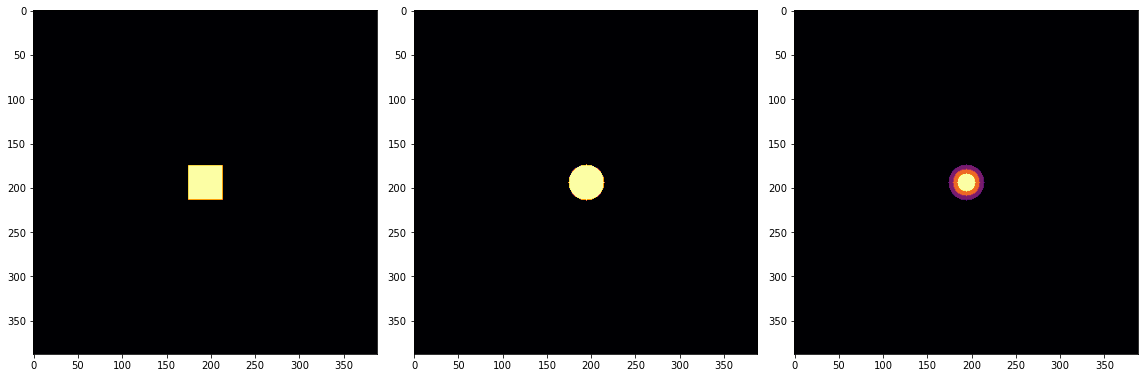

In [14]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
ax[0].imshow(cuad.src_matrix)
ax[1].imshow(circ.src_matrix)
ax[2].imshow(rin.src_matrix)
plt.tight_layout()

## Transformación identidad
Desarrollo incluido en el método $\texttt{transf\_identidad}$.

La fuente será una matriz $F(i_1, i_2)$ y  tendrá tamaño $n_y\times n_y$. A la imagen le corresponderá una matriz $I(j_1, j_2)$ de tamaño $n_x\times n_x$, con $n_x$ más grande (por ejemplo 3 veces) que $n_y$. Escojamos escalas relativas $x_l=8$ e $y_l=4$ (variable). Con las escalas y el número de píxeles se calcula el tamaño de cada píxel en el plano imagen $x_s=2x_l/(n_x-1)$ y en el plano fuente $y_s=2y_l/(n_y-1)$.

Se leerá la fuente recorriendo $i_1$ e $i_2$ y la imagen recorriendo $j_1$ e $j_2$. Posteriormente se transforman los pixeles de la imagen a coordenadas $x_1=-x_l+(j_1-1)x_s$ y lo mismo con $x_2$. Se aplica la transformación inversa identidad $\vec{x}\rightarrow\vec{y}=\vec{x}$. Posteriormente se transforman las coordenadas en el plano de la fuente a píxeles: $i_1=(y_1+y_l)/y_s+1$

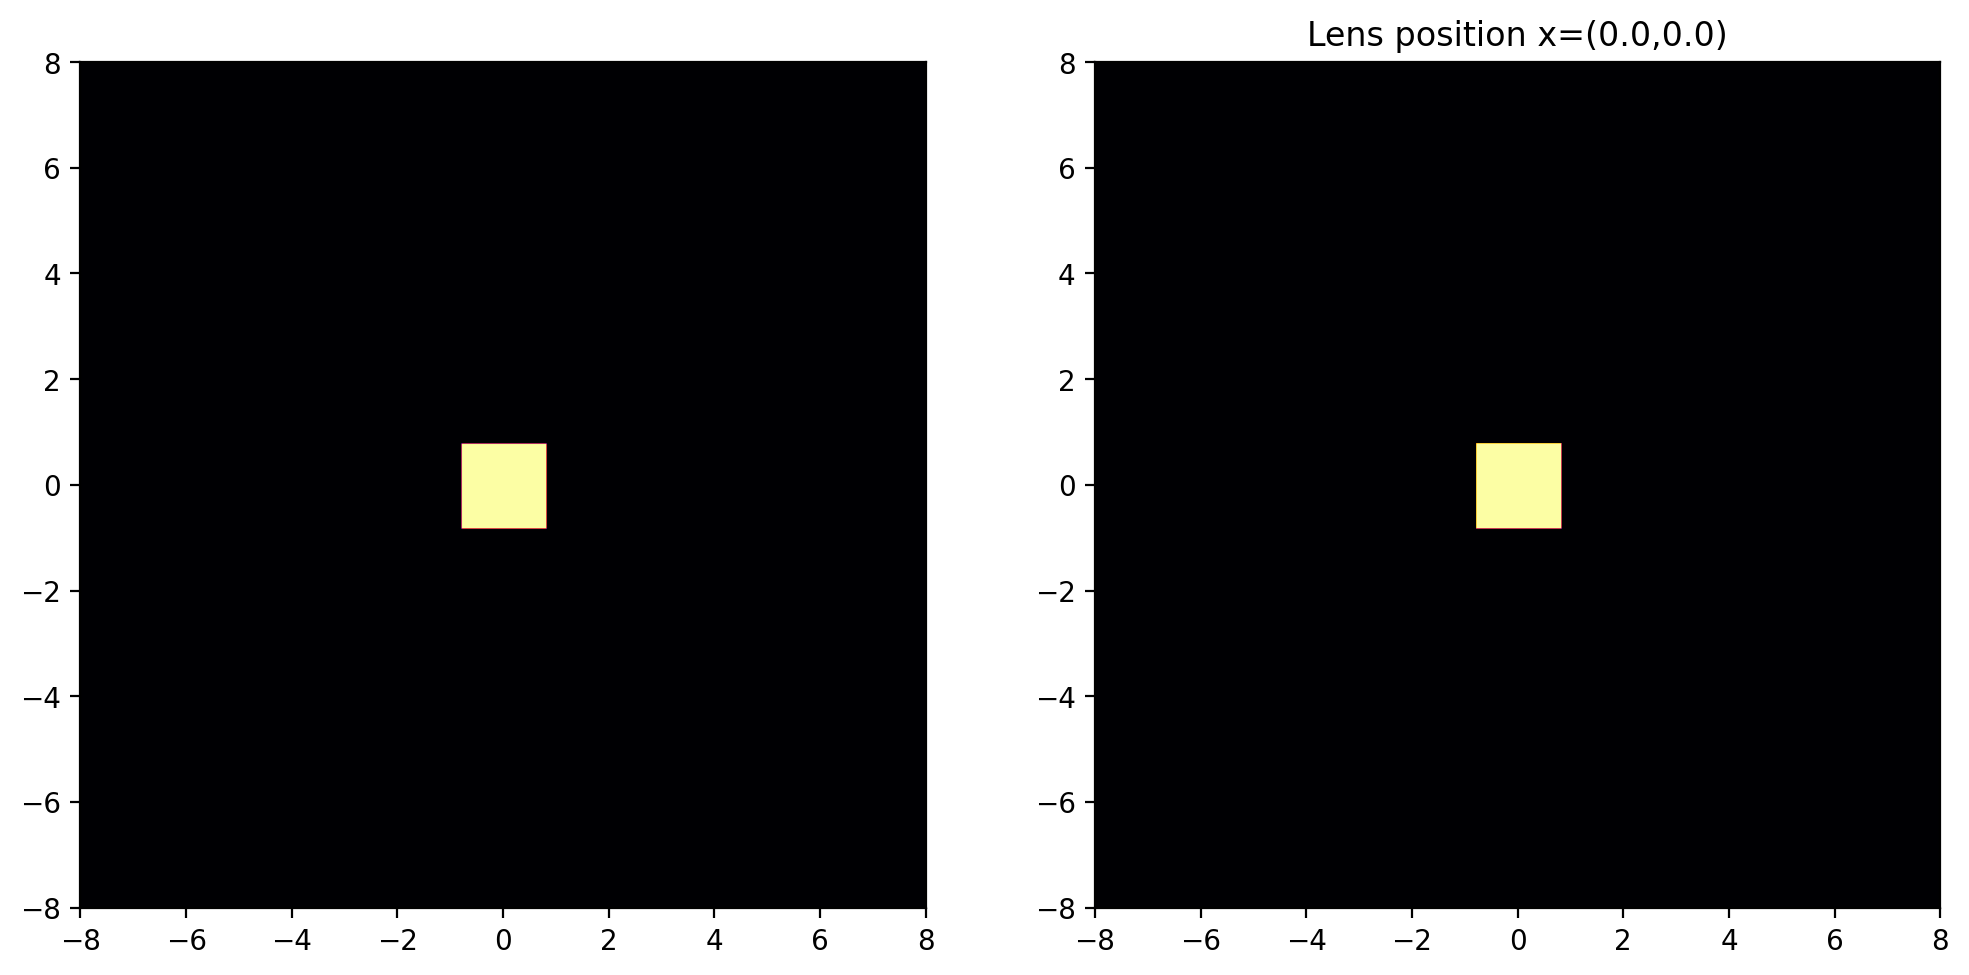

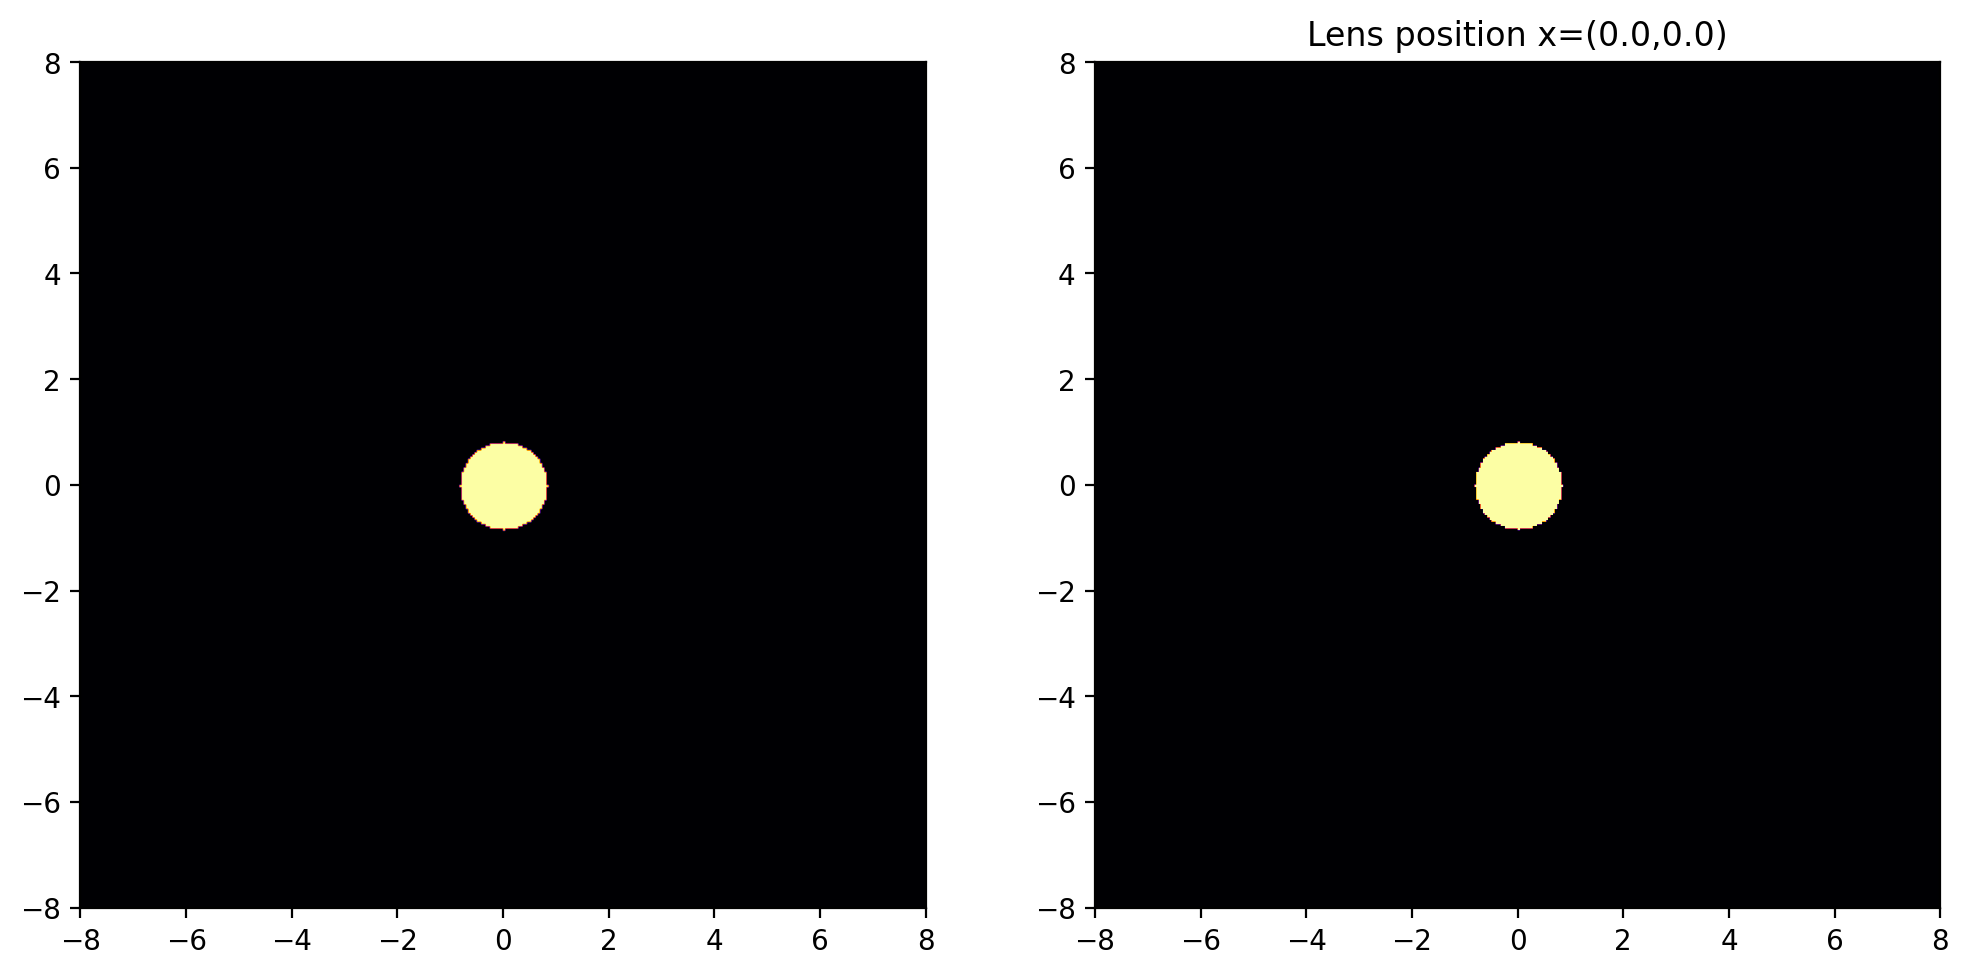

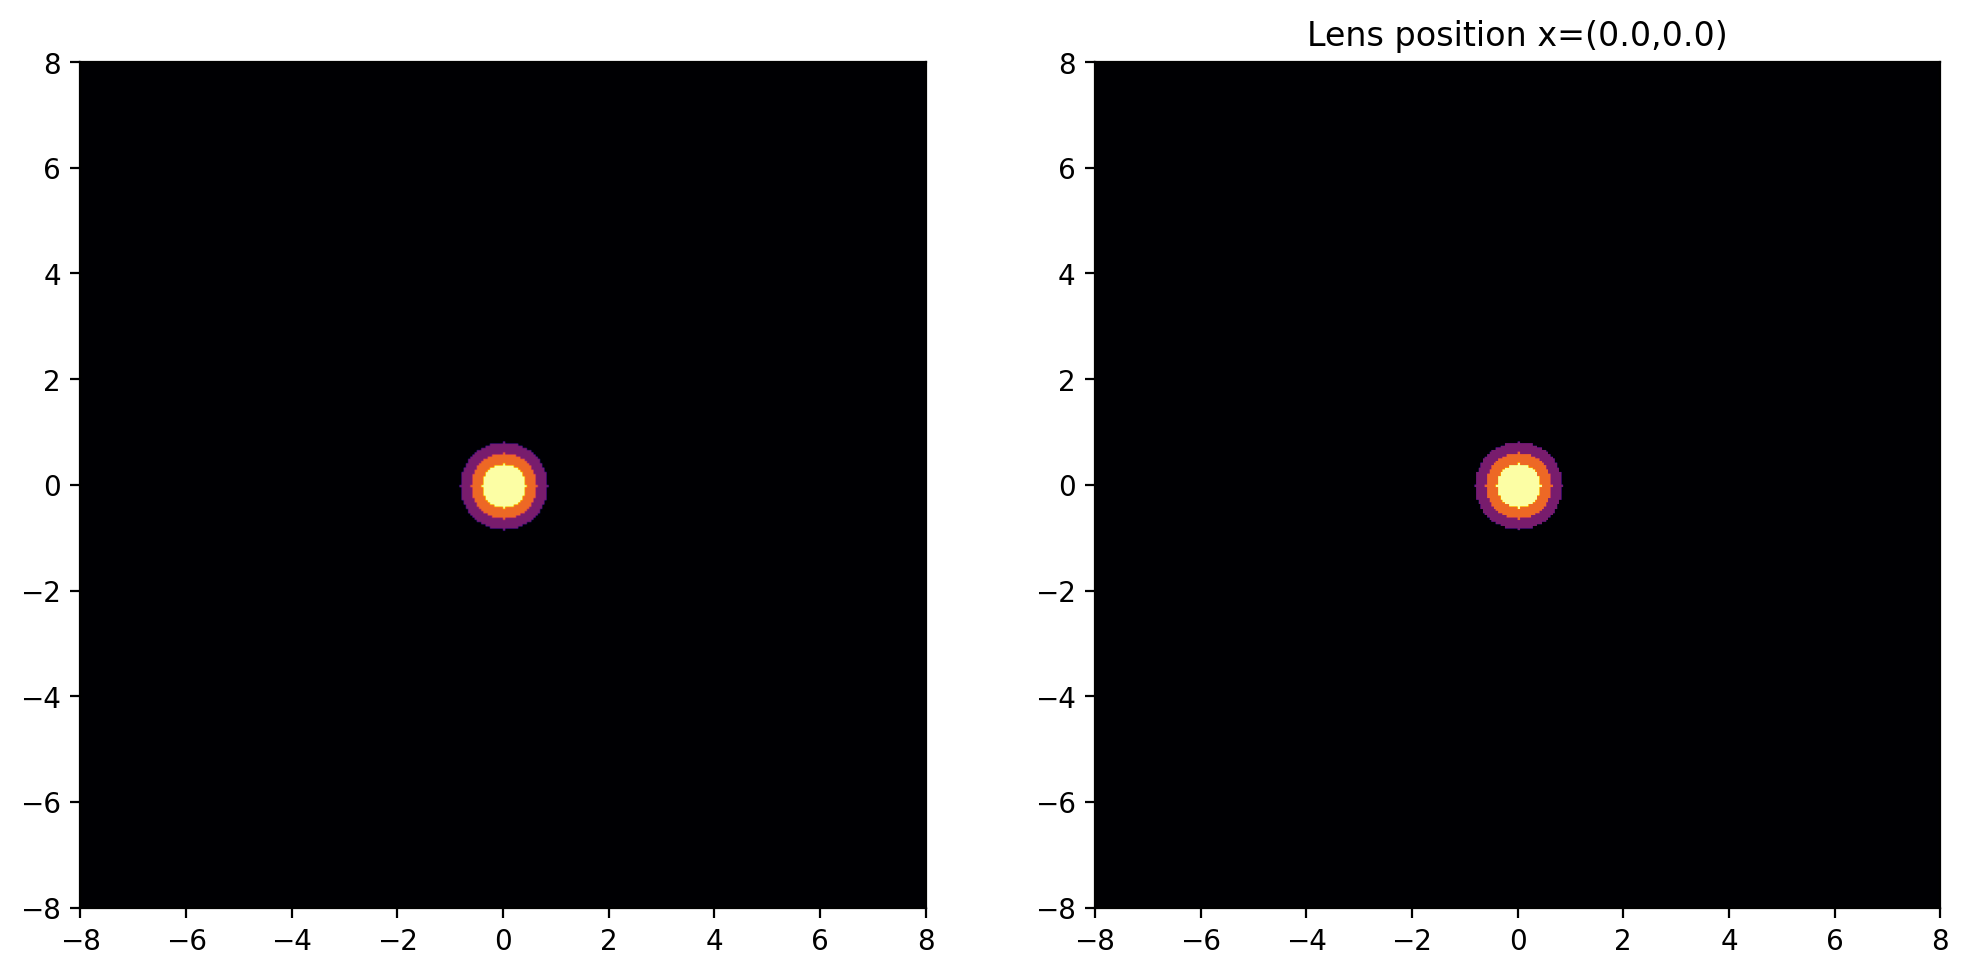

In [6]:
cuad.transf(ploteo = True, identidad = True)
circ.transf(ploteo = True, identidad = True)
rin.transf(ploteo = True, identidad = True)

Tests con mismo tamaño y baja resolución en la imagen. Se aprecian píxeles mucho más gruesos y se pierde detalle.

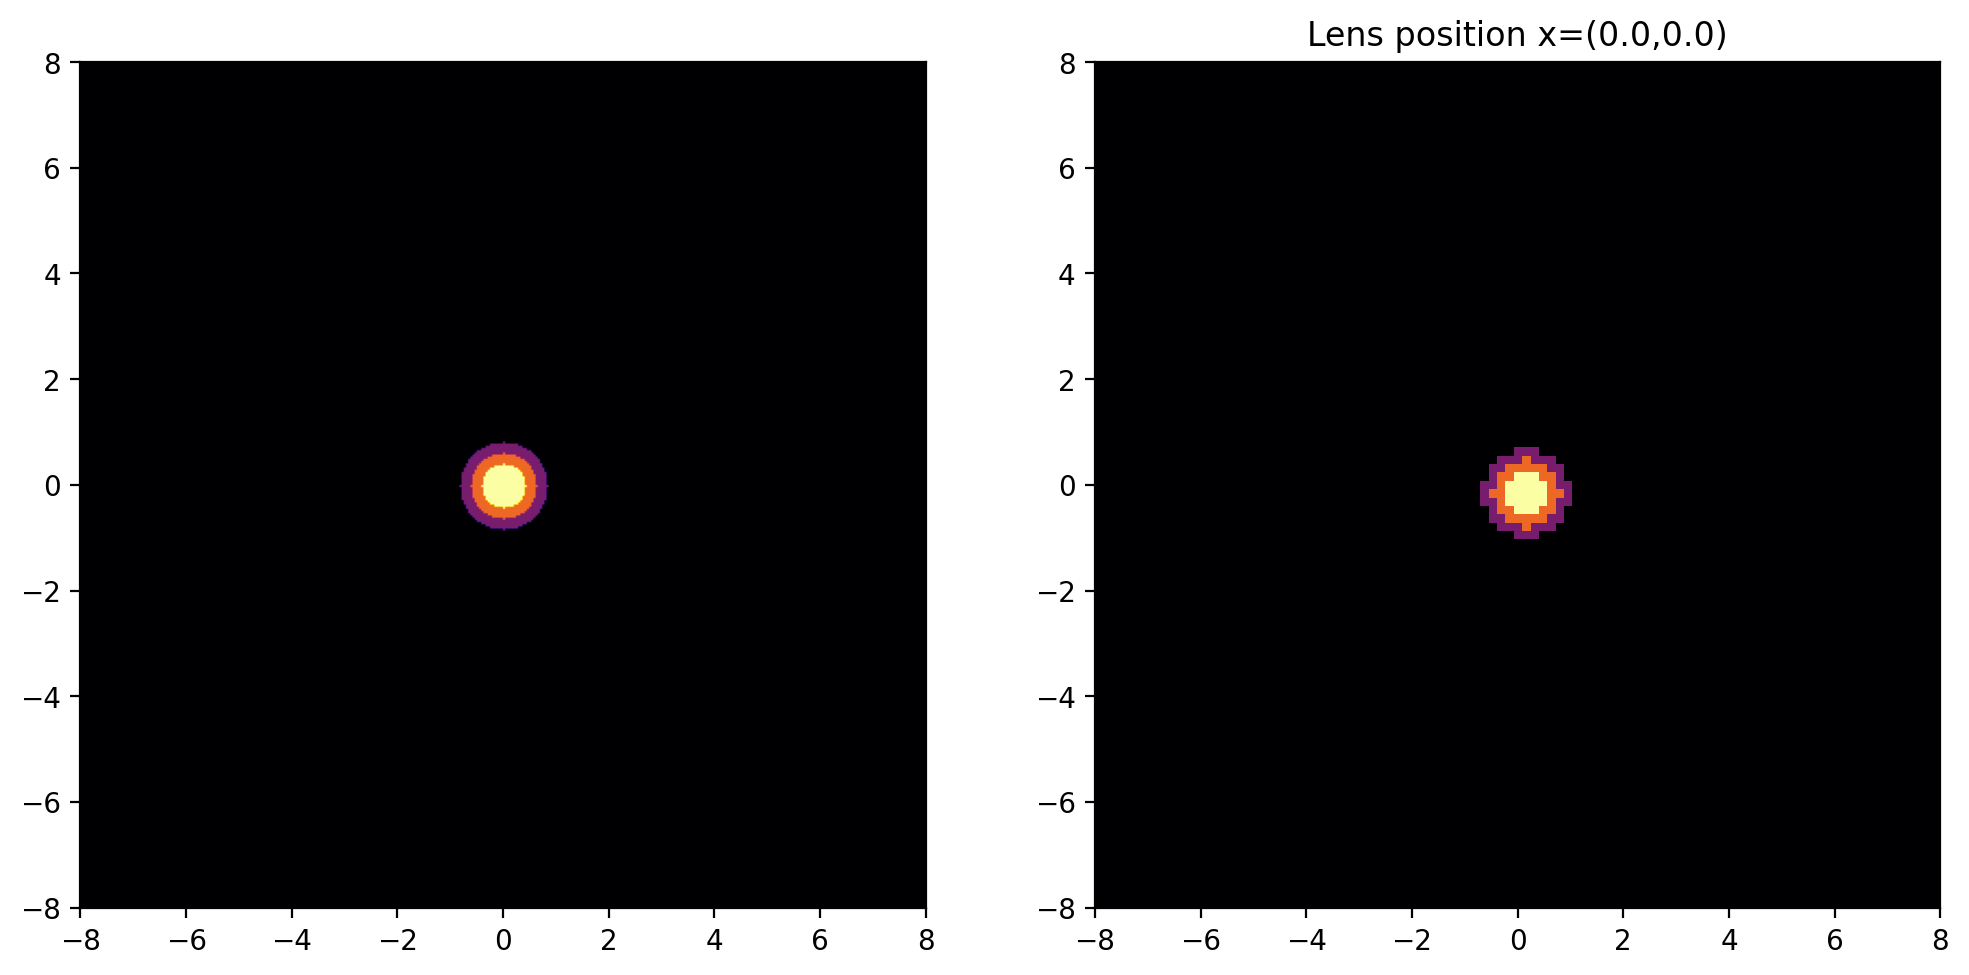

In [7]:
rin_low = LG(nx = 101, ny = 388, xl = 8, yl = 8)
rin_low.source(value = 1, rings = True,  r = 20, n_r = 3, w_r = 5)
rin_low.transf(ploteo = True, identidad = True)

## Lente por masa puntual
Se define una masa puntual $m_l$ en un punto $\mathbf{x_d}=(x_d,y_d)$, y la función de deflección será $\mathbf{\alpha}=m_l(\mathbf{x}-\mathbf{x_d})/|\mathbf{x}-\mathbf{x_d}|^2$ con $\mathbf{x}=(x_1,x_2)$ las coordeandas del rayo en el plano de la fuente.

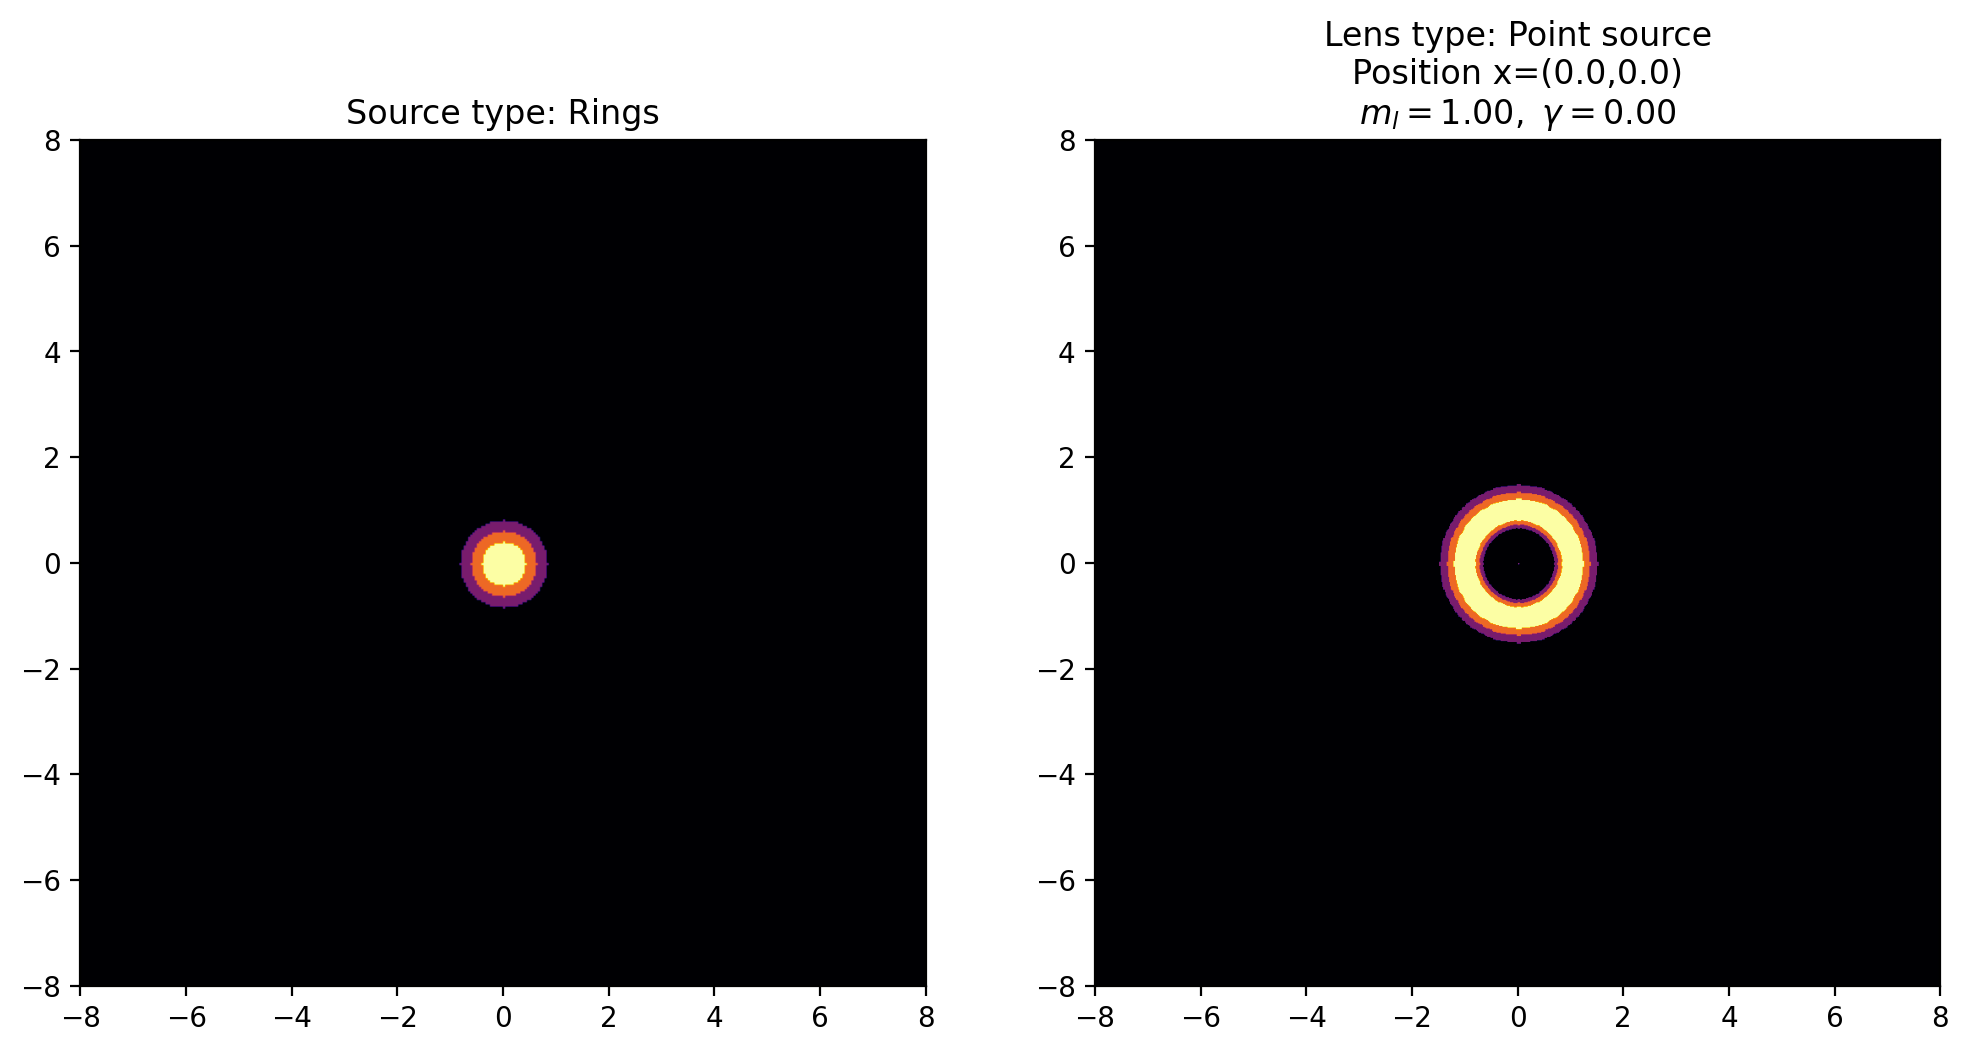

In [56]:

rin.transf(ploteo = True, puntual = True, ml=1, x0 = (0,0))
#rin.transf(ploteo = True, puntual = True, ml=1, x0 = (0,4))
#rin.transf(ploteo = True, puntual = True, ml=1, x0 = (0,1))


#cuad.transf(ploteo = True, puntual = True, ml=1, x0 = (0,0))

In [9]:
# xis = np.array([0, 0.1, 0.2, 0.4, 0.6, 1, 1.5, 2])
for i in range(40):
    cuad.transf(ploteo = True, puntual = True, ml=1, x0 = (0,i*0.1))
    output_path = os.path.join(path, f'frames_cuad/frame_{i}.png')
    plt.savefig(output_path)
    plt.close()

KeyboardInterrupt: 

In [21]:
import imageio
import os

def create_animation(image_folder, output_folder, video_name, fps):     
        images_all = sorted(os.listdir(image_folder))
        
        images = sorted(images_all, key=lambda x: int(''.join(filter(str.isdigit, x))))
        
        # output_folder = 'C:/Users/osole/OneDrive/Documentos/4/TFG/TFG_videos'  # Path to the folder where you want to save the video
        video_file = os.path.join(output_folder, video_name)  # Output video file path
        # fps = 10
        
        # Create an empty list to store the frames
        frames = []
        
        # Load each image and append it to the frames list
        for image_name in images:
            image_path = os.path.join(image_folder, image_name)
            frame = imageio.imread(image_path)
            frames.append(frame)
        
        # Save the frames as a video using imageio.mimwrite()
        # imageio.mimwrite(video_file, frames, fps=fps)
        # Save the frames as a video with specific video format and codec
        output_params = {'fps': fps, 'codec': 'libx264'}
        imageio.mimwrite(video_file, frames, **output_params)

In [ ]:
create_animation(path+'/frames', path+'/movies', '0to2.mp4', 8)

In [13]:
create_animation(path+'/frames_cuad', path+'/movies', '0to4_cuad.mp4', 8)

C:\Users\osole\AppData\Local\Temp\ipykernel_36600\692778377.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)


### Animación conjunta
Se crea una animación del desplazamiento de la posición de la lente para la fuente cuadrada y el anillo

In [26]:
for i in range(40):
    x0 = (0,i*0.1)
    cuad.transf(ploteo = False, puntual = True, ml=1, x0 = x0)
    rin.transf(ploteo = False, puntual = True, ml=1, x0 = x0)
    fig, ax = plt.subplots(2,2, figsize = (10,8))
    ax[0,0].imshow(cuad.src_matrix, extent = (-cuad.yl,cuad.yl, -cuad.yl,cuad.yl))
    ax[0,1].imshow(cuad.i, extent = (-cuad.xl,cuad.xl, -cuad.xl,cuad.xl))
    ax[1,0].imshow(rin.src_matrix, extent = (-rin.yl,rin.yl, -rin.yl,rin.yl))
    ax[1,1].imshow(rin.i, extent = (-rin.xl,rin.xl, -rin.xl,rin.xl))
    ax[0,0].set_title('Source')
    ax[0,1].set_title('Image')
    ax[1,0].set_title('Source')
    ax[1,1].set_title('Image')
    # ax[1,1].set_title('Lens position x=(%.1f,%.1f)'%(x0[1],x0[0]))
    fig.suptitle('Lens position x=(%.1f,%.1f)'%(x0[1],x0[0]))
    lin = fig.add_axes([0, 0.47, 1, 0.03], frameon=False, facecolor='w')
    lin.set_xticks([])
    lin.set_yticks([])
    plt.axhline(0.5, color='black', linestyle='dotted')
    plt.tight_layout()
    
    output_path = os.path.join(path, f'frames_both/frame_{i}.png')
    plt.savefig(output_path)
    plt.close()

C:\Users\osole\AppData\Local\Temp\ipykernel_36600\2423870354.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [27]:
create_animation(path+'/frames_both', path+'/movies', '0to4_both.mp4', 8)

C:\Users\osole\AppData\Local\Temp\ipykernel_36600\692778377.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)


## Lente cuadrupolar / Chang-Refsdal
Extensión simple de la lente puntual que incluye el efecto de un campo gravitatorio suave por la inclusión de un término cuadripolar en el ángulo de deflección. Con $\kappa$ la convergencia y $\gamma$ el $\textit{shear}$ queda $$\mathbf{\alpha}=
\begin{pmatrix}
\kappa+\gamma & 0\\
0 & \kappa-\gamma
\end{pmatrix}
\mathbf{x}+m_l \frac{(\mathbf{x}-\mathbf{x_d})}{|\mathbf{x}-\mathbf{x_d}|^2}$$

In [39]:
for i in range(16):
    rin.transf(ploteo = True, cuadru = True, ml=1, x0 = (0,1), gam = 0.05*(i), kap=0)
    output_path = os.path.join(path, f'frames_cuadru_rin/frame_{i}.png')
    plt.savefig(output_path)
    plt.close()

C:\Users\osole\AppData\Local\Temp\ipykernel_67836\2801715696.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


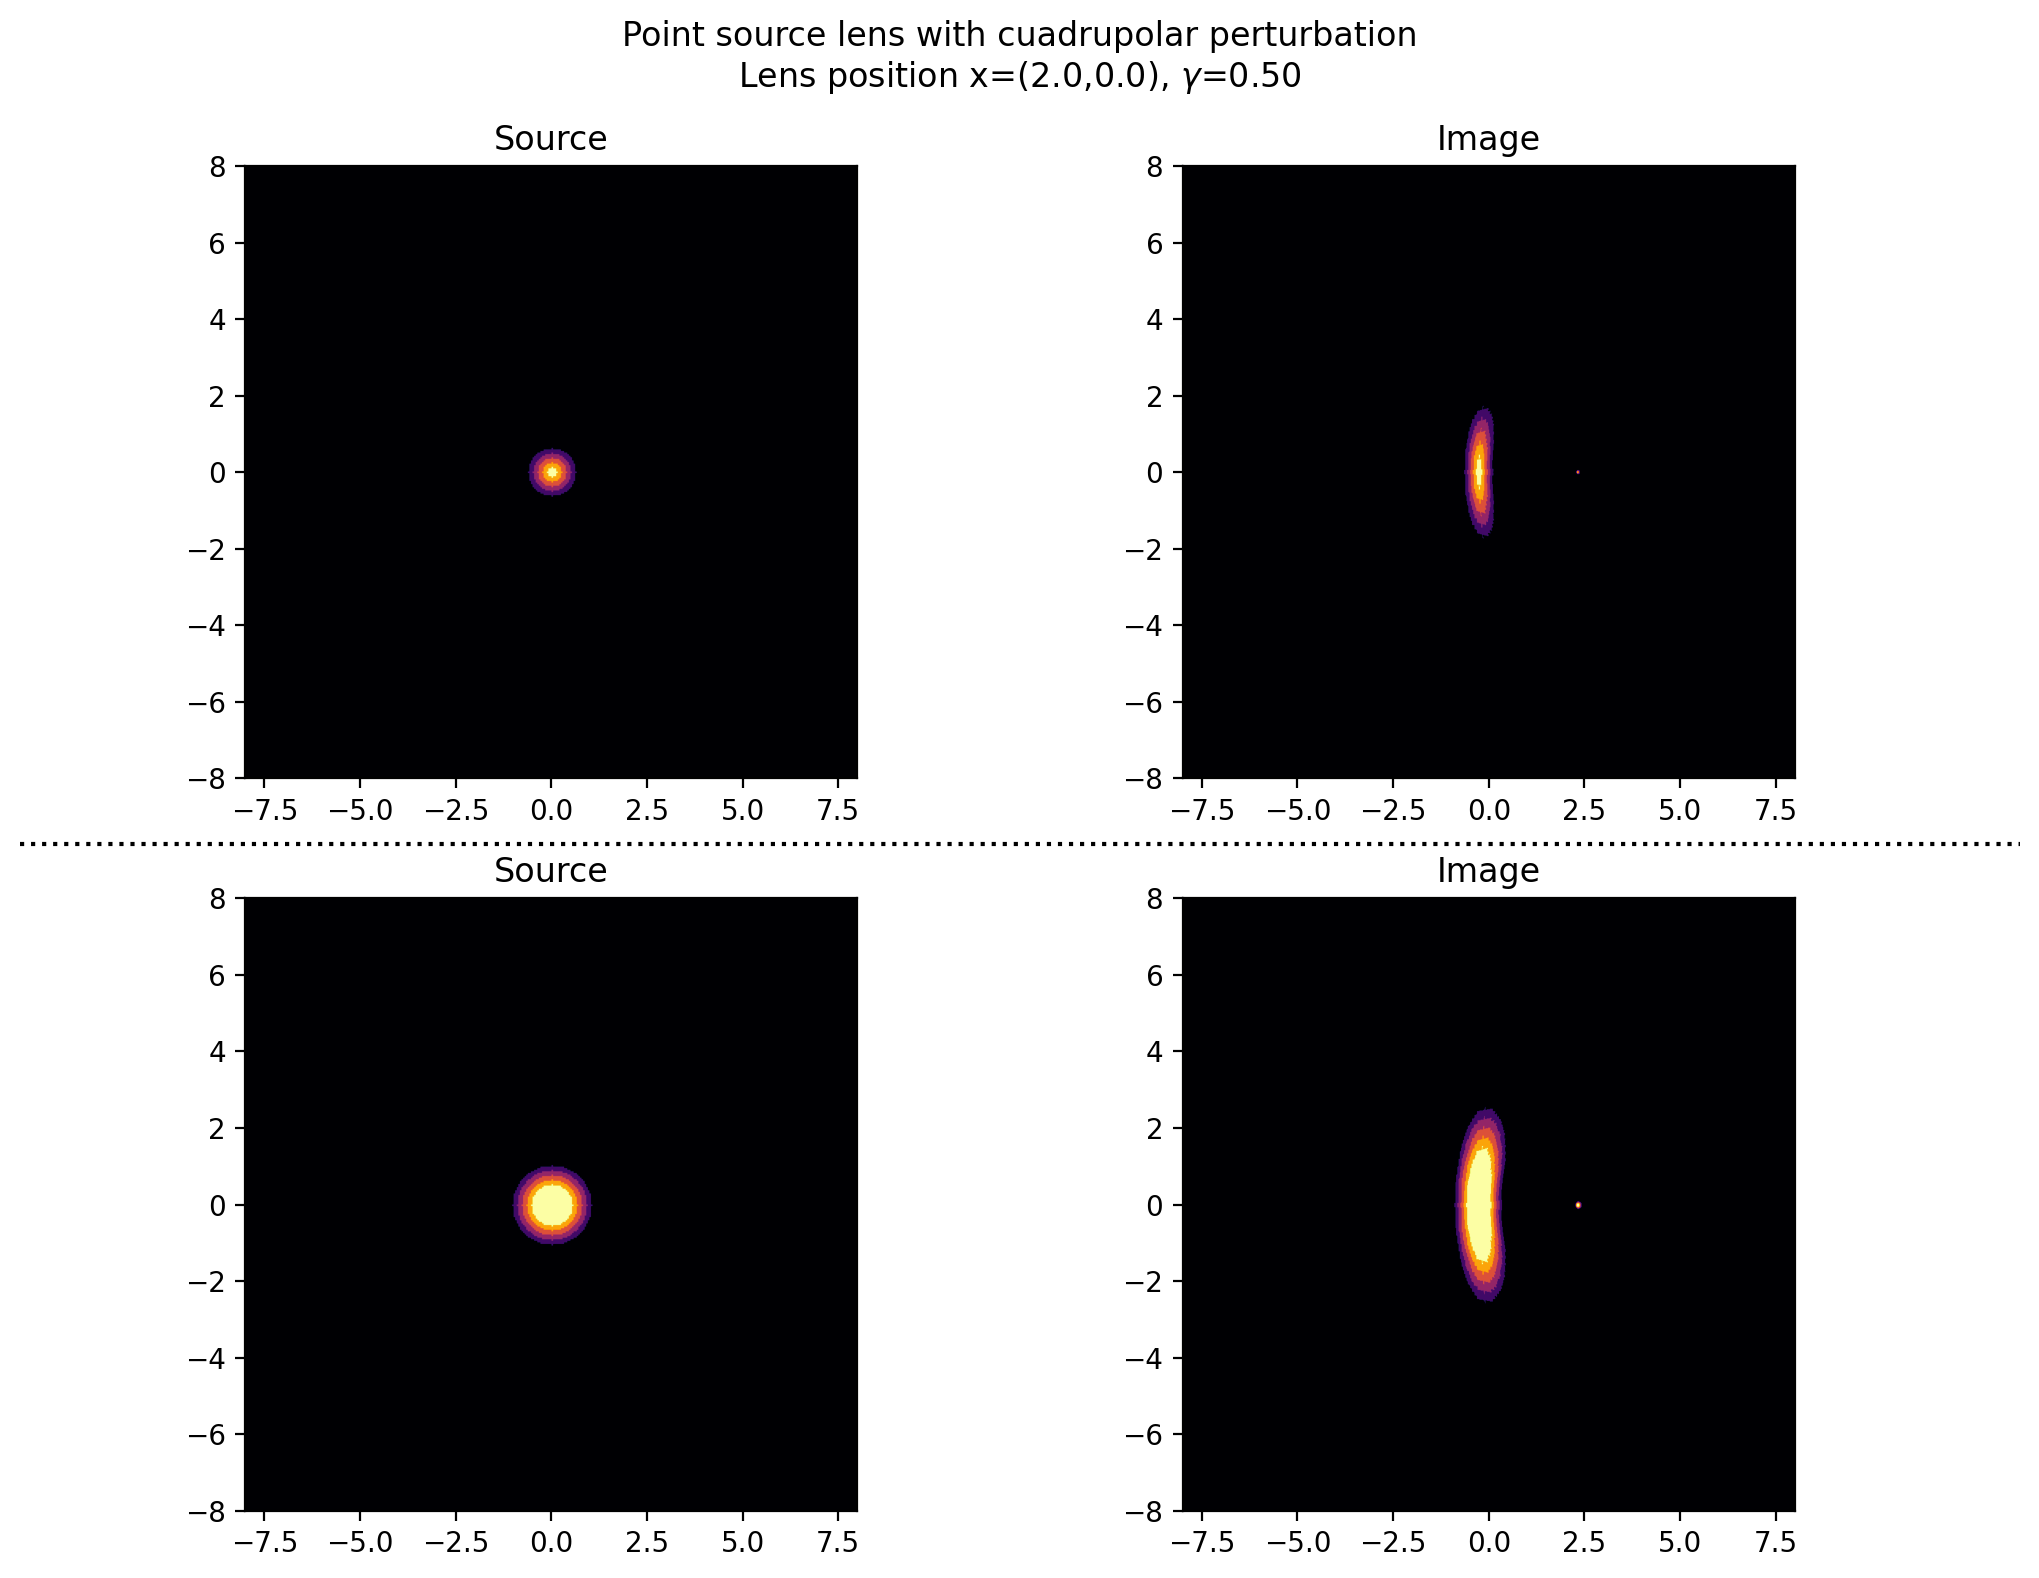

In [51]:
rin1 = LG()
rin1.source(1, rings = True, r = 15, n_r = 5, w_r = 3)

rin2 = LG()
rin2.source(1, rings = True, r = 25, n_r = 5, w_r = 3)

for i in range(14):
    x0 = (0,0.5)
    gamma = 0.05*(i+1)
    rin1.transf(ploteo = False, cuadru = True, ml=1, x0 = x0, gam = gamma, kap = 0)
    rin2.transf(ploteo = False, cuadru = True, ml=1, x0 = x0, gam = gamma, kap = 0)
    fig, ax = plt.subplots(2,2, figsize = (10,8))
    ax[0,0].imshow(rin1.src_matrix, extent = (-rin1.yl,rin1.yl, -rin1.yl,rin1.yl))
    ax[0,1].imshow(rin1.i, extent = (-rin1.xl,rin1.xl, -rin1.xl,rin1.xl))
    ax[1,0].imshow(rin2.src_matrix, extent = (-rin2.yl,rin2.yl, -rin2.yl,rin2.yl))
    ax[1,1].imshow(rin2.i, extent = (-rin2.xl,rin2.xl, -rin2.xl,rin2.xl))
    ax[0,0].set_title('Source')
    ax[0,1].set_title('Image')
    ax[1,0].set_title('Source')
    ax[1,1].set_title('Image')
    fig.suptitle('Point source lens with cuadrupolar perturbation\nLens position x=(%.1f,%.1f), $\gamma$=%.2f'%(x0[1],x0[0],gamma))
    lin = fig.add_axes([0, 0.45, 1, 0.03], frameon=False, facecolor='w')
    lin.set_xticks([])
    lin.set_yticks([])
    plt.axhline(0.5, color='black', linestyle='dotted')
    plt.tight_layout()
    
    #output_path = os.path.join(path, f'frames_cuadru_rin_05/frame_{i}.png')
    #plt.savefig(output_path)
    #plt.close()

In [49]:
create_animation(path+'/frames_cuadru_rin_05', path+'/movies', 'cuadru_rin_05.mp4', 6)

C:\Users\osole\AppData\Local\Temp\ipykernel_67836\692778377.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)


## Lente isoterma singular
Es la solución general asociada a una distribución Maxwelliana de velocidades de las componentes de un sistema (como las estrellas de una galaxia). La solución particular está dada por la esfera isoterma singular (SIS), adoptada para el bulbo de las galaxias espirales, elípticas y cúmulos de galaxias.
$$\mathbf{\alpha}=m_l(\mathbf{x}-\mathbf{x_d})/|\mathbf{x}-\mathbf{x_d}|$$

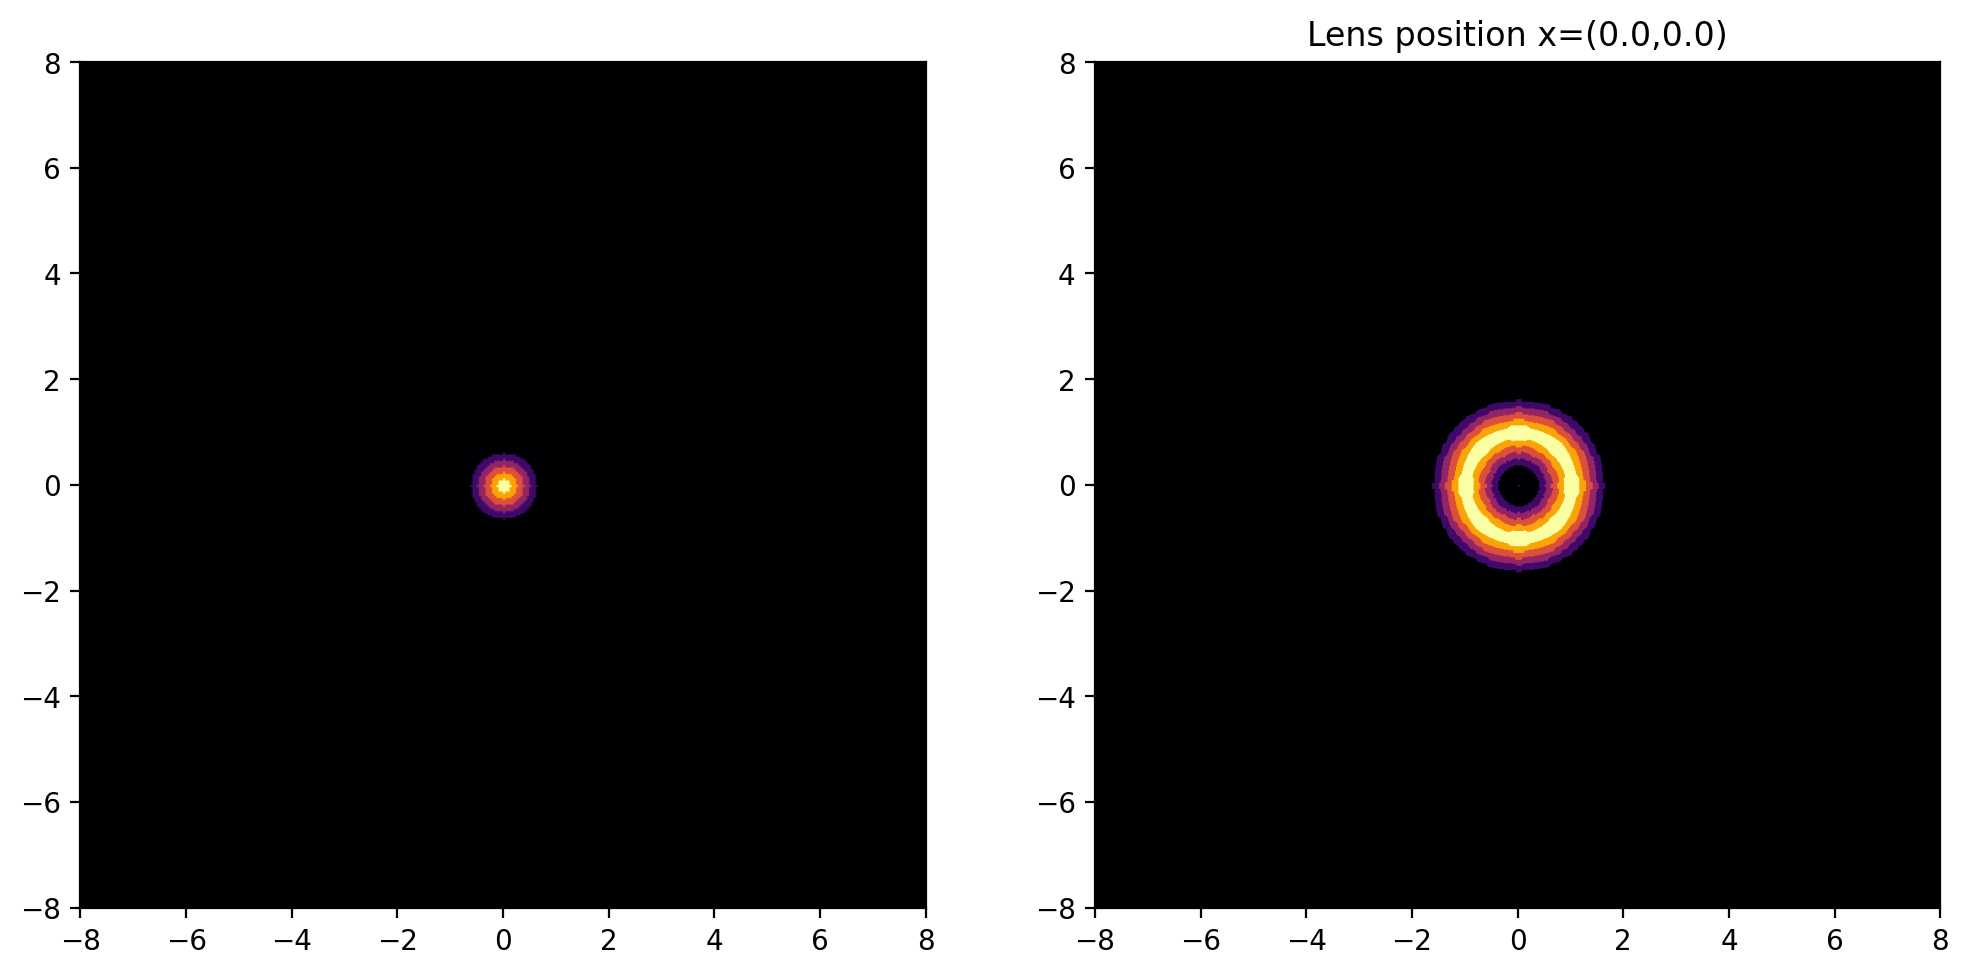

In [61]:
rin1 = LG()
rin1.source(1, rings = True, r = 15, n_r = 5, w_r = 3)

x0 = (0,0)
rin1.transf(ploteo = True, SIS = True, ml=1, x0 = x0)


## Lente isoterma singular con perturbación cuadrupolar
Perturbación cuadrupolar del SIS que sigue: 
$$\mathbf{\alpha}=
\begin{pmatrix}
\kappa+\gamma & 0\\
0 & \kappa-\gamma
\end{pmatrix}
\mathbf{x}+m_l \frac{(\mathbf{x}-\mathbf{x_d})}{|\mathbf{x}-\mathbf{x_d}|}$$

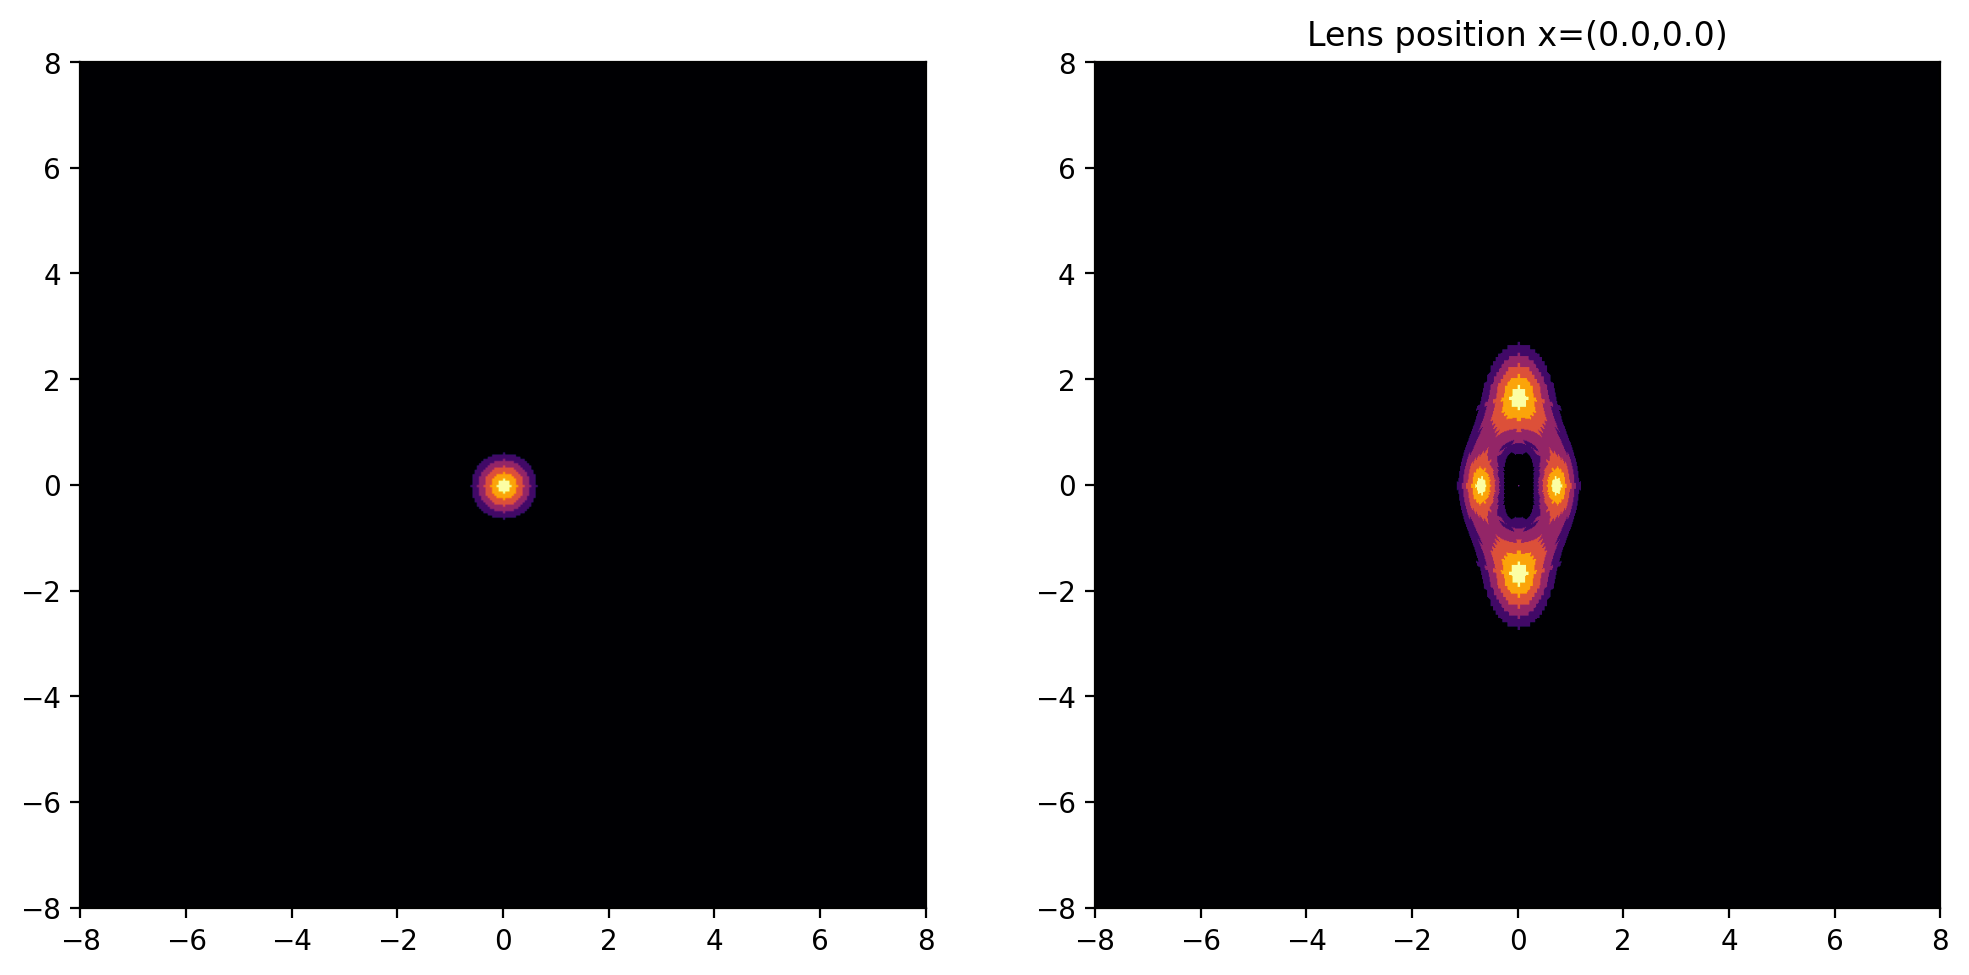

In [66]:
rin1 = LG()
rin1.source(1, rings = True, r = 15, n_r = 5, w_r = 3)

x0 = (0,0)
gamma = .4
rin1.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma)

# Comparación con imágenes de CASTLES
http://www.cfa.harvard.edu/castles/

## H1413+117
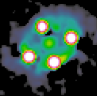

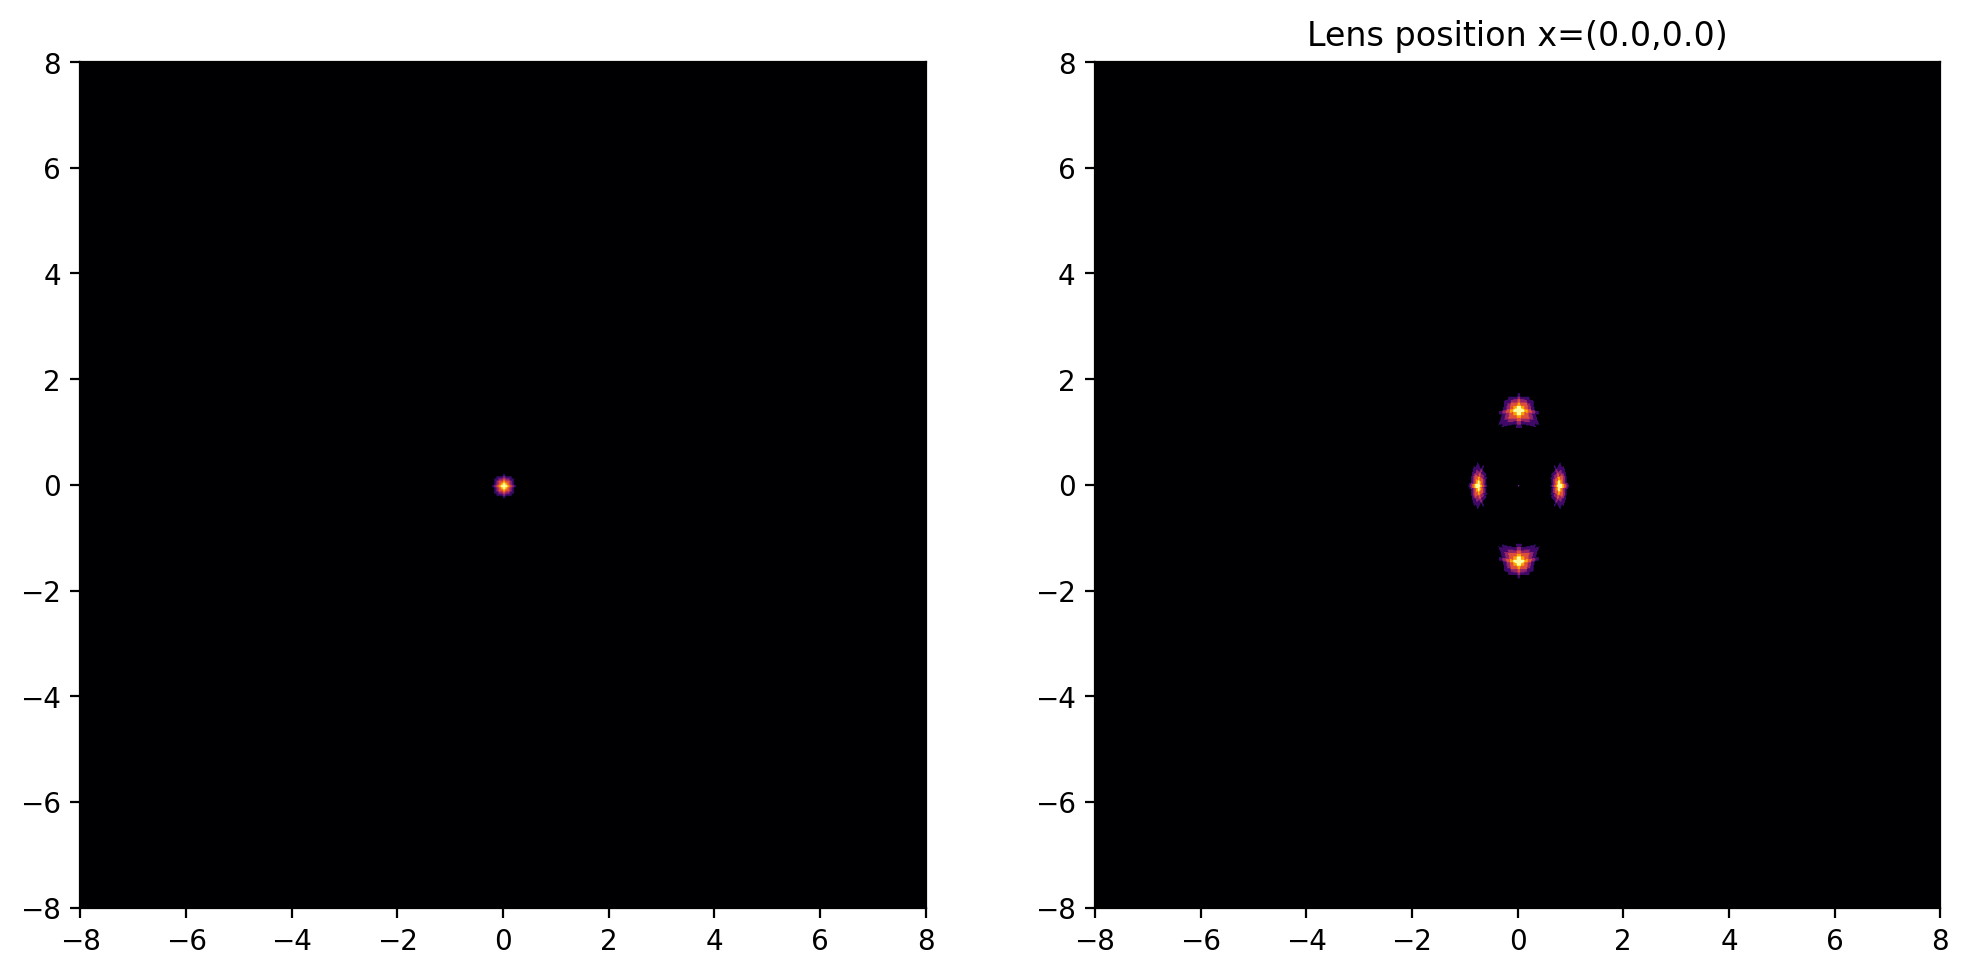

In [71]:
rin1 = LG()
rin1.source(1, rings = True, r = 5, n_r = 5, w_r = 1)

x0 = (0,0)
gamma = .3
rin1.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma)

## PG1115+080
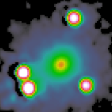 

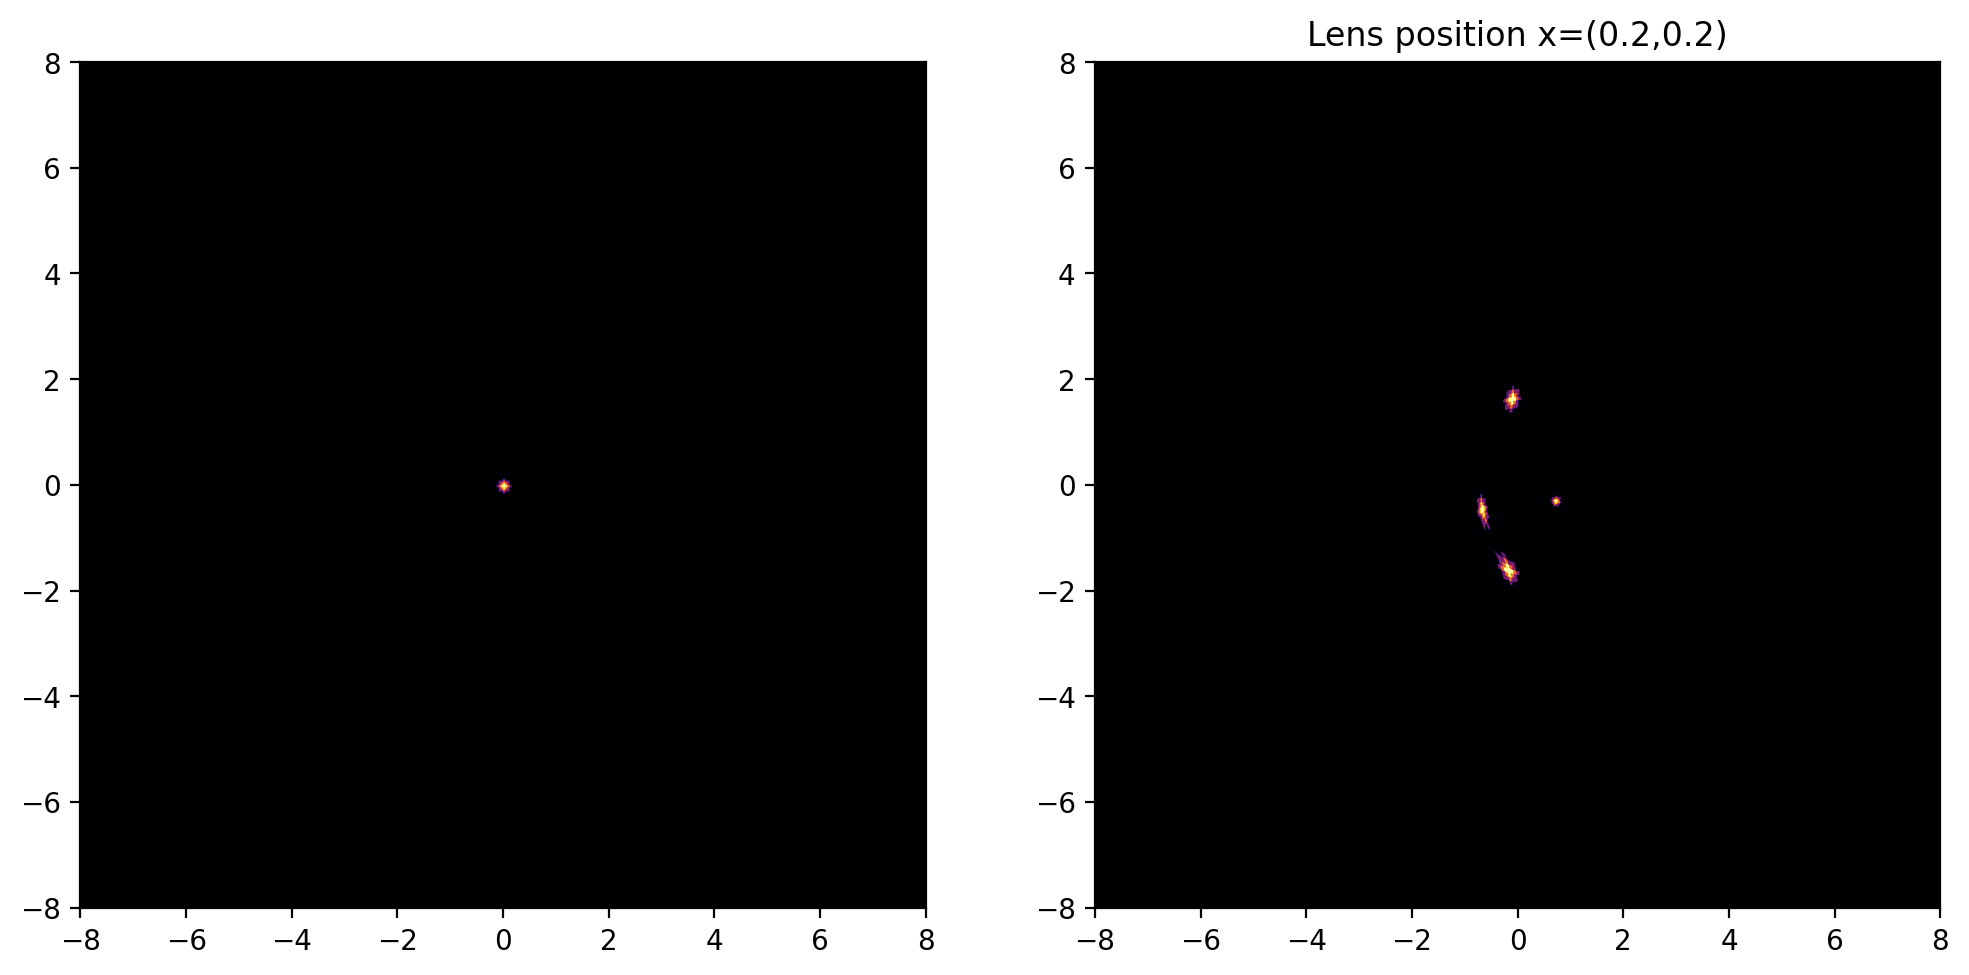

In [77]:
rin = LG()
rin.source(1, rings = True, r = 3, n_r = 3, w_r = 1)

x0 = (0.2,0.2)
gamma = .4
rin.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma)

## B1422+231
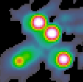

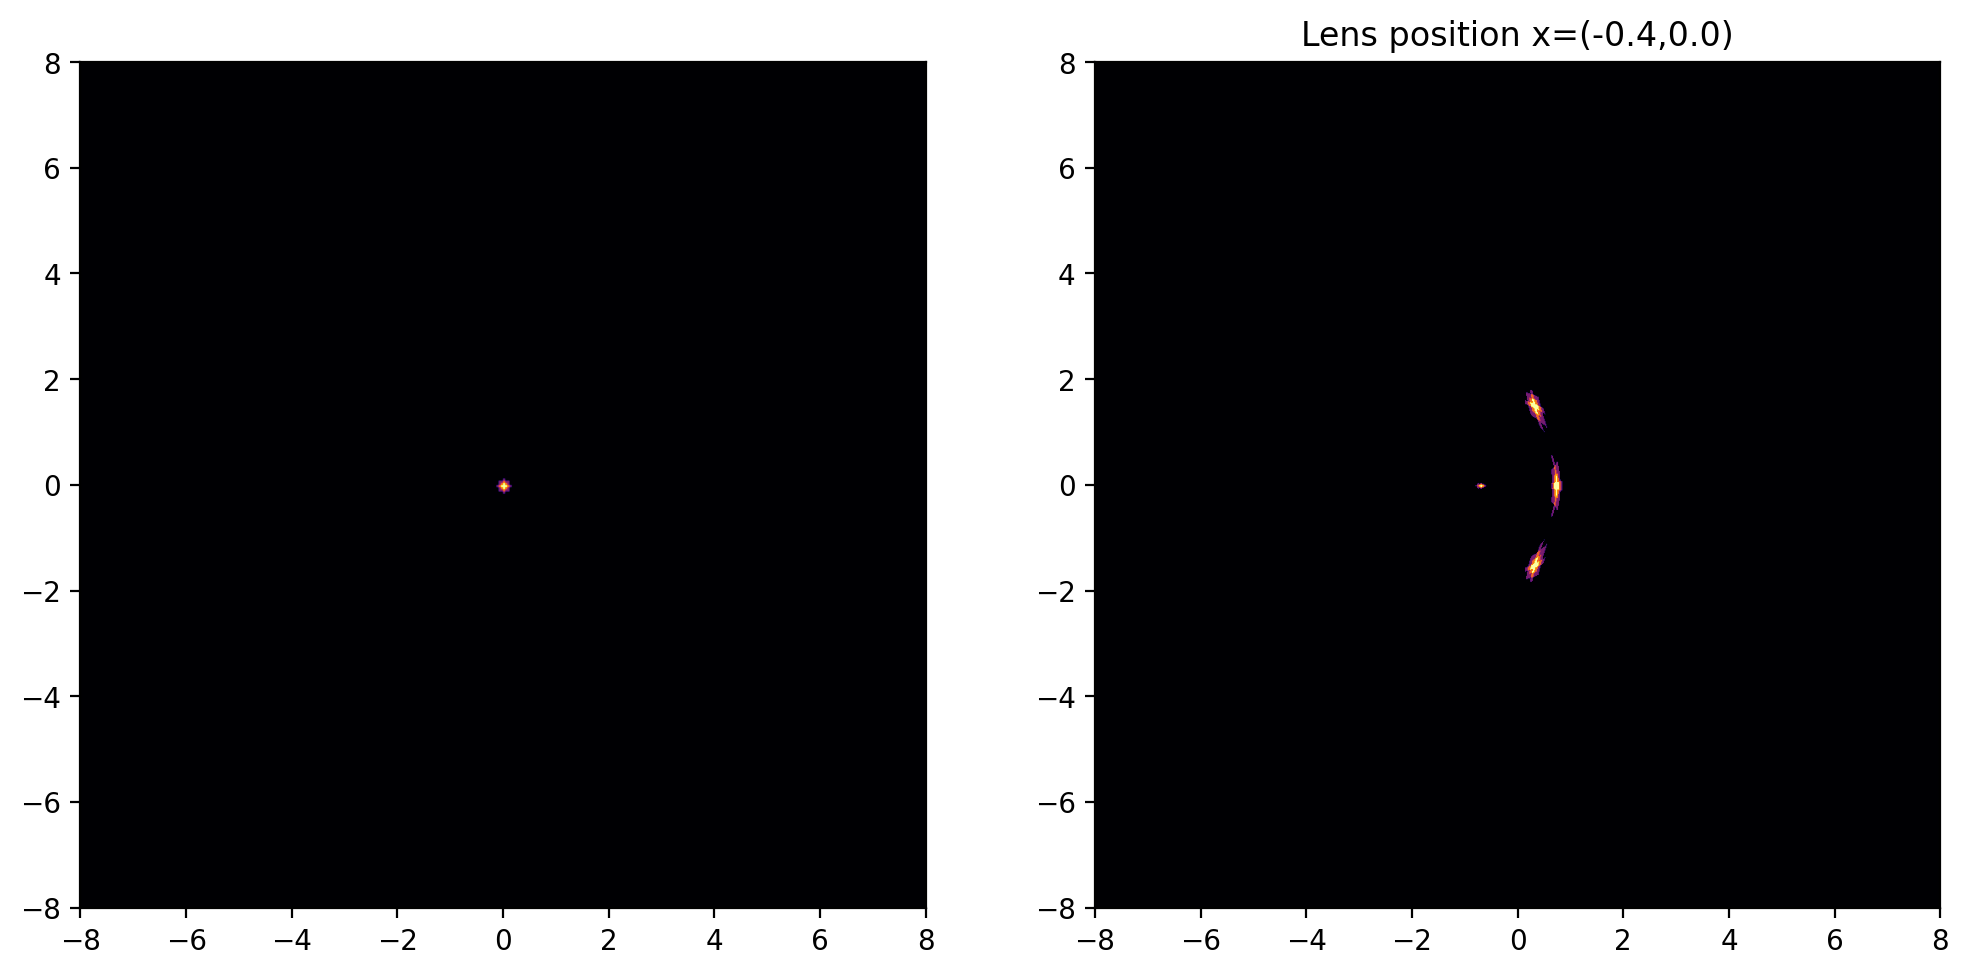

In [79]:
rin = LG()
rin.source(1, rings = True, r = 3, n_r = 3, w_r = 1)

x0 = (0,-0.4)
gamma = .4
rin.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma)

## B1938+666 
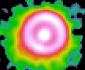

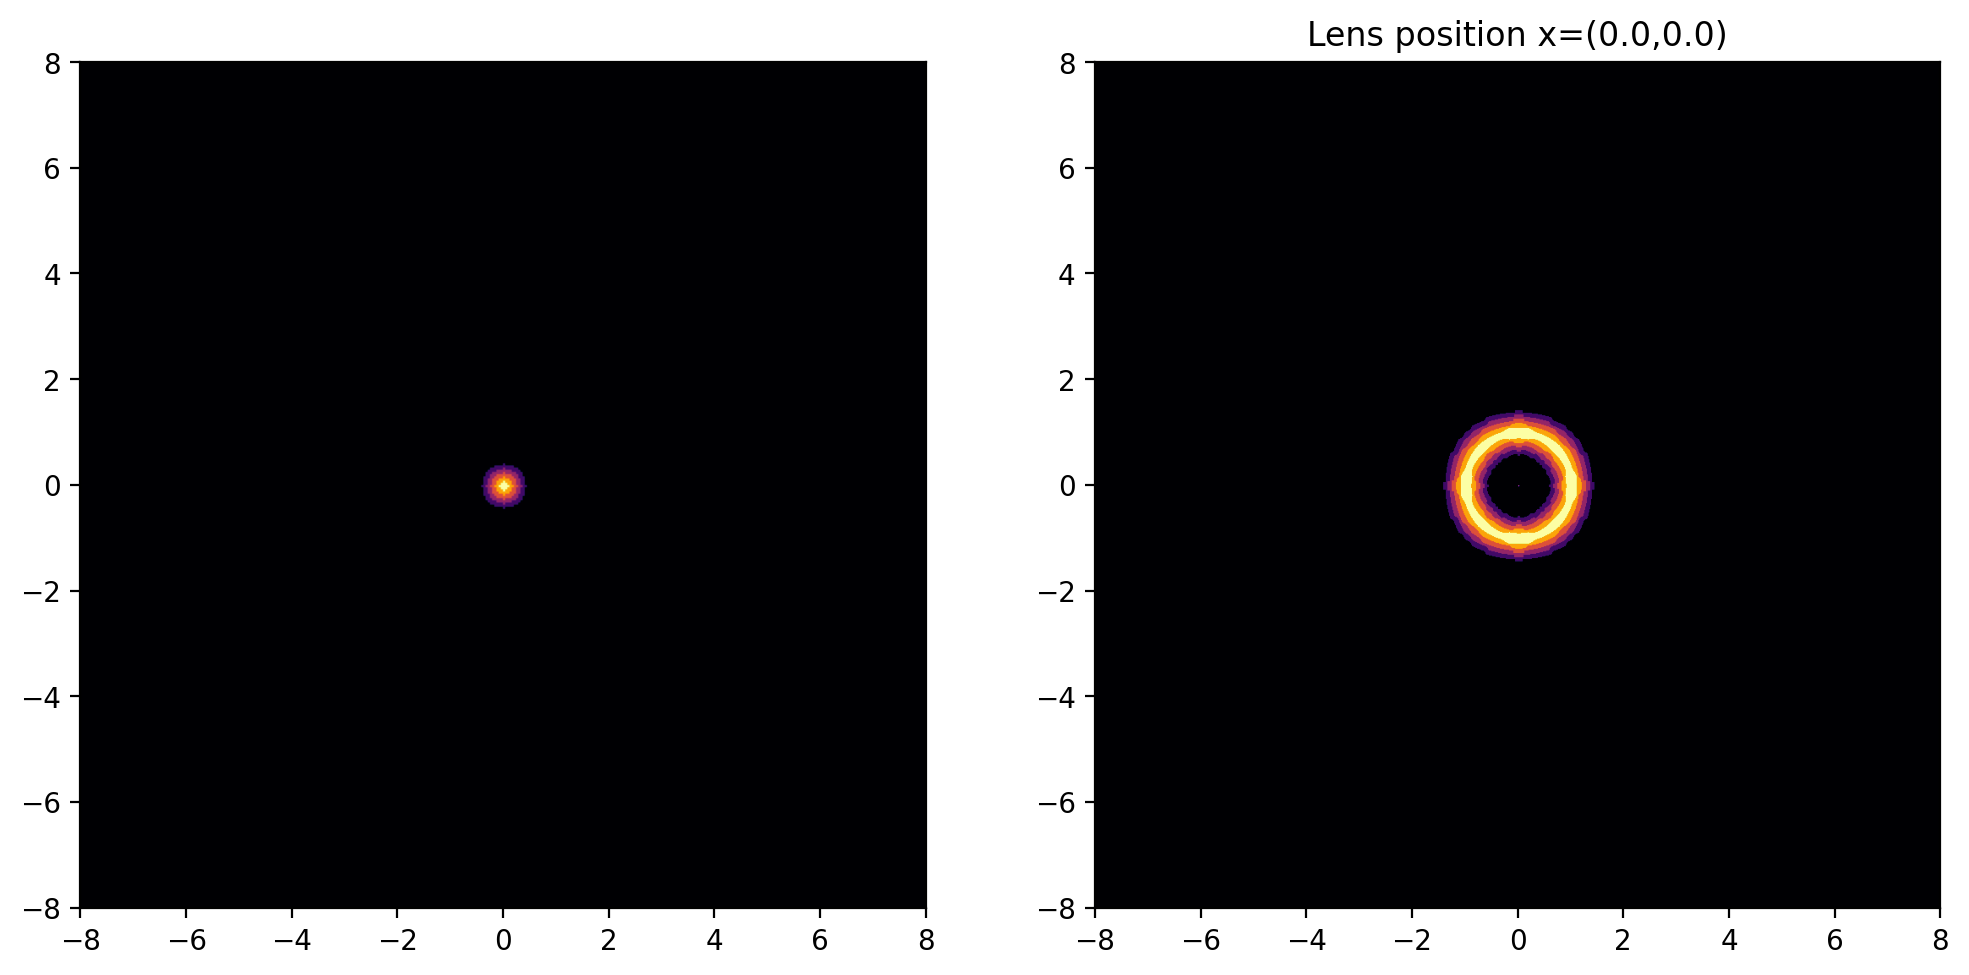

In [83]:
rin = LG()
rin.source(1, rings = True, r = 10, n_r = 5, w_r = 2)

x0 = (0,0)
gamma = 0
rin.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma)

## B0631+519 
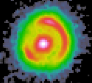

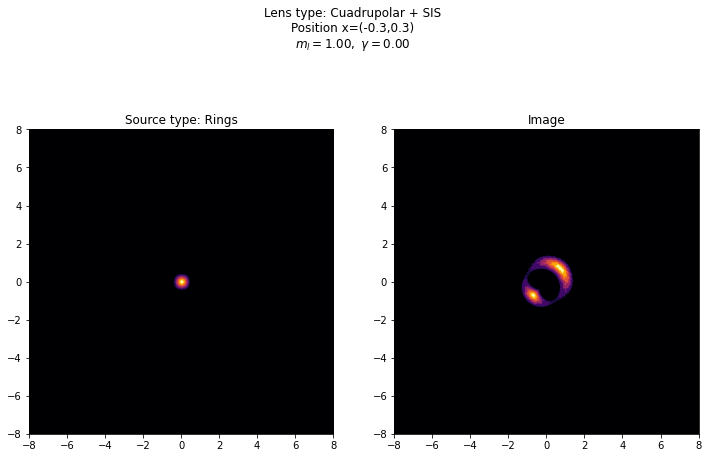

In [15]:
rin = LG()
rin.source(1, rings = True, r = 10, n_r = 5, w_r = 2)

x0 = (0.3,-0.3)
gamma = 0
rin.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma)

# Animación con imagen del Hubble Deep Field y efecto de lente gravitatoria

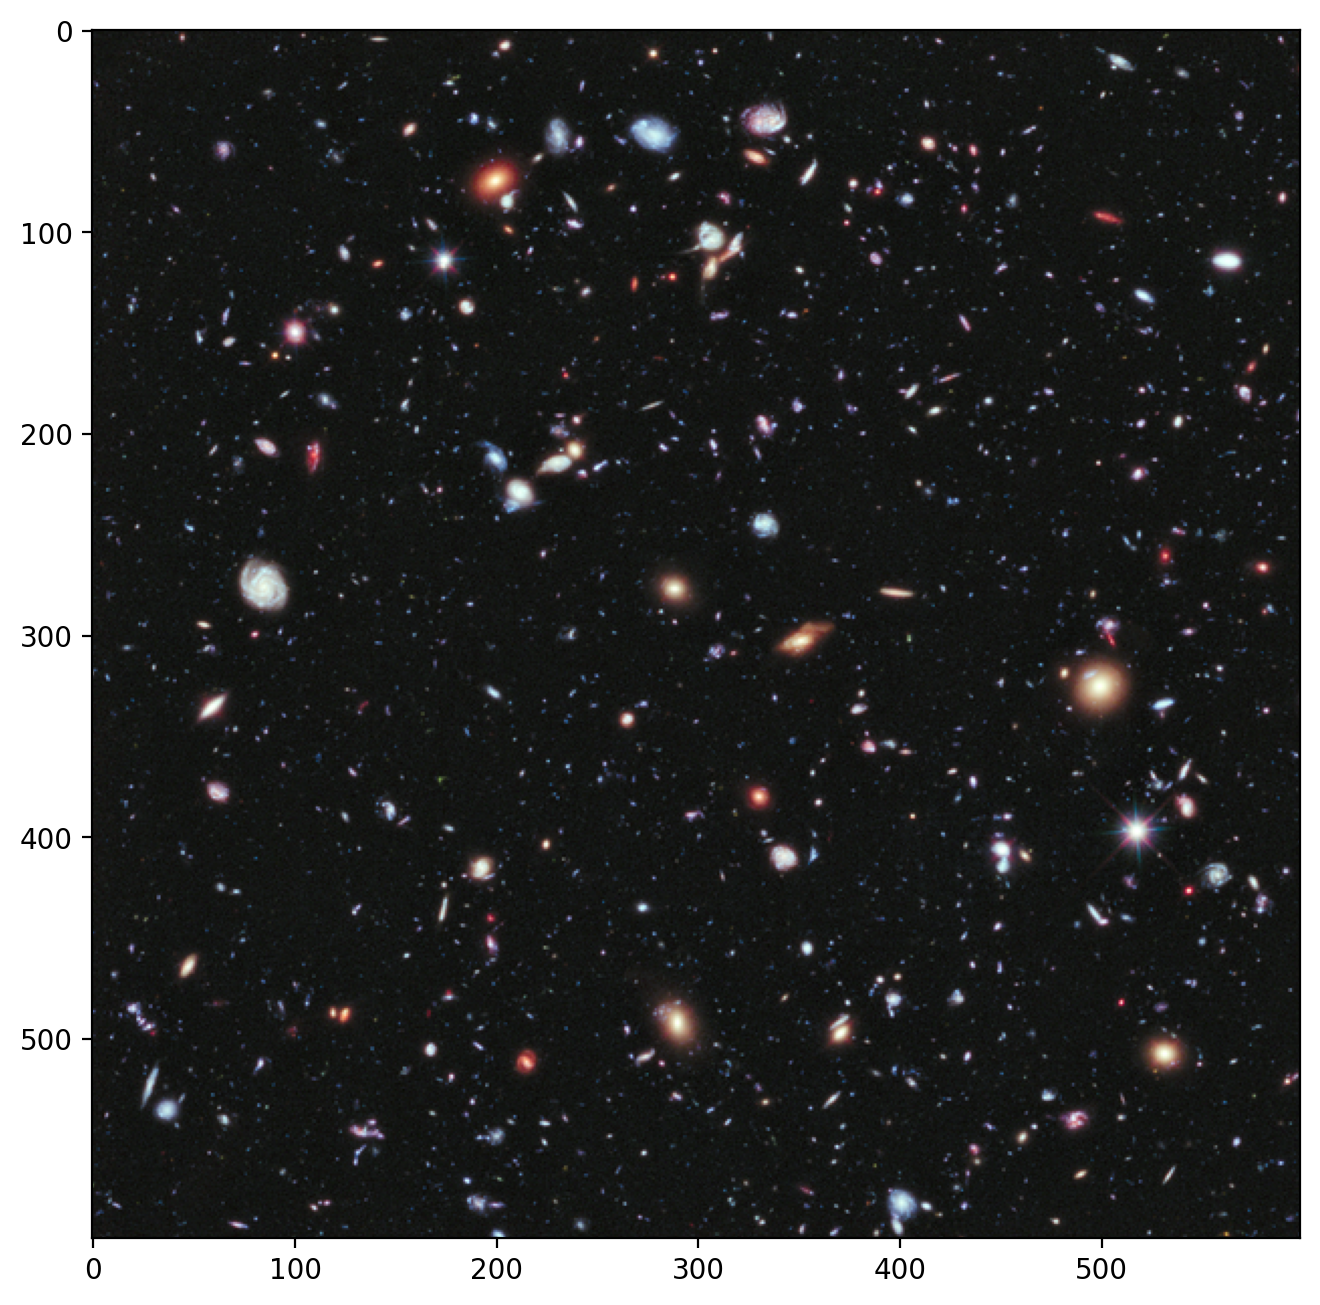

In [40]:
import PIL, urllib

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Hubble_Extreme_Deep_Field_%28full_resolution%29.png/687px-Hubble_Extreme_Deep_Field_%28full_resolution%29.png'
img = np.array(PIL.Image.open(urllib.request.urlopen(url)))

red = img[:,:img.shape[0],0]
green = img[:,:img.shape[0],1]
blue = img[:,:img.shape[0],2]

rgb = np.dstack((red,green,blue))

plt.imshow(rgb)

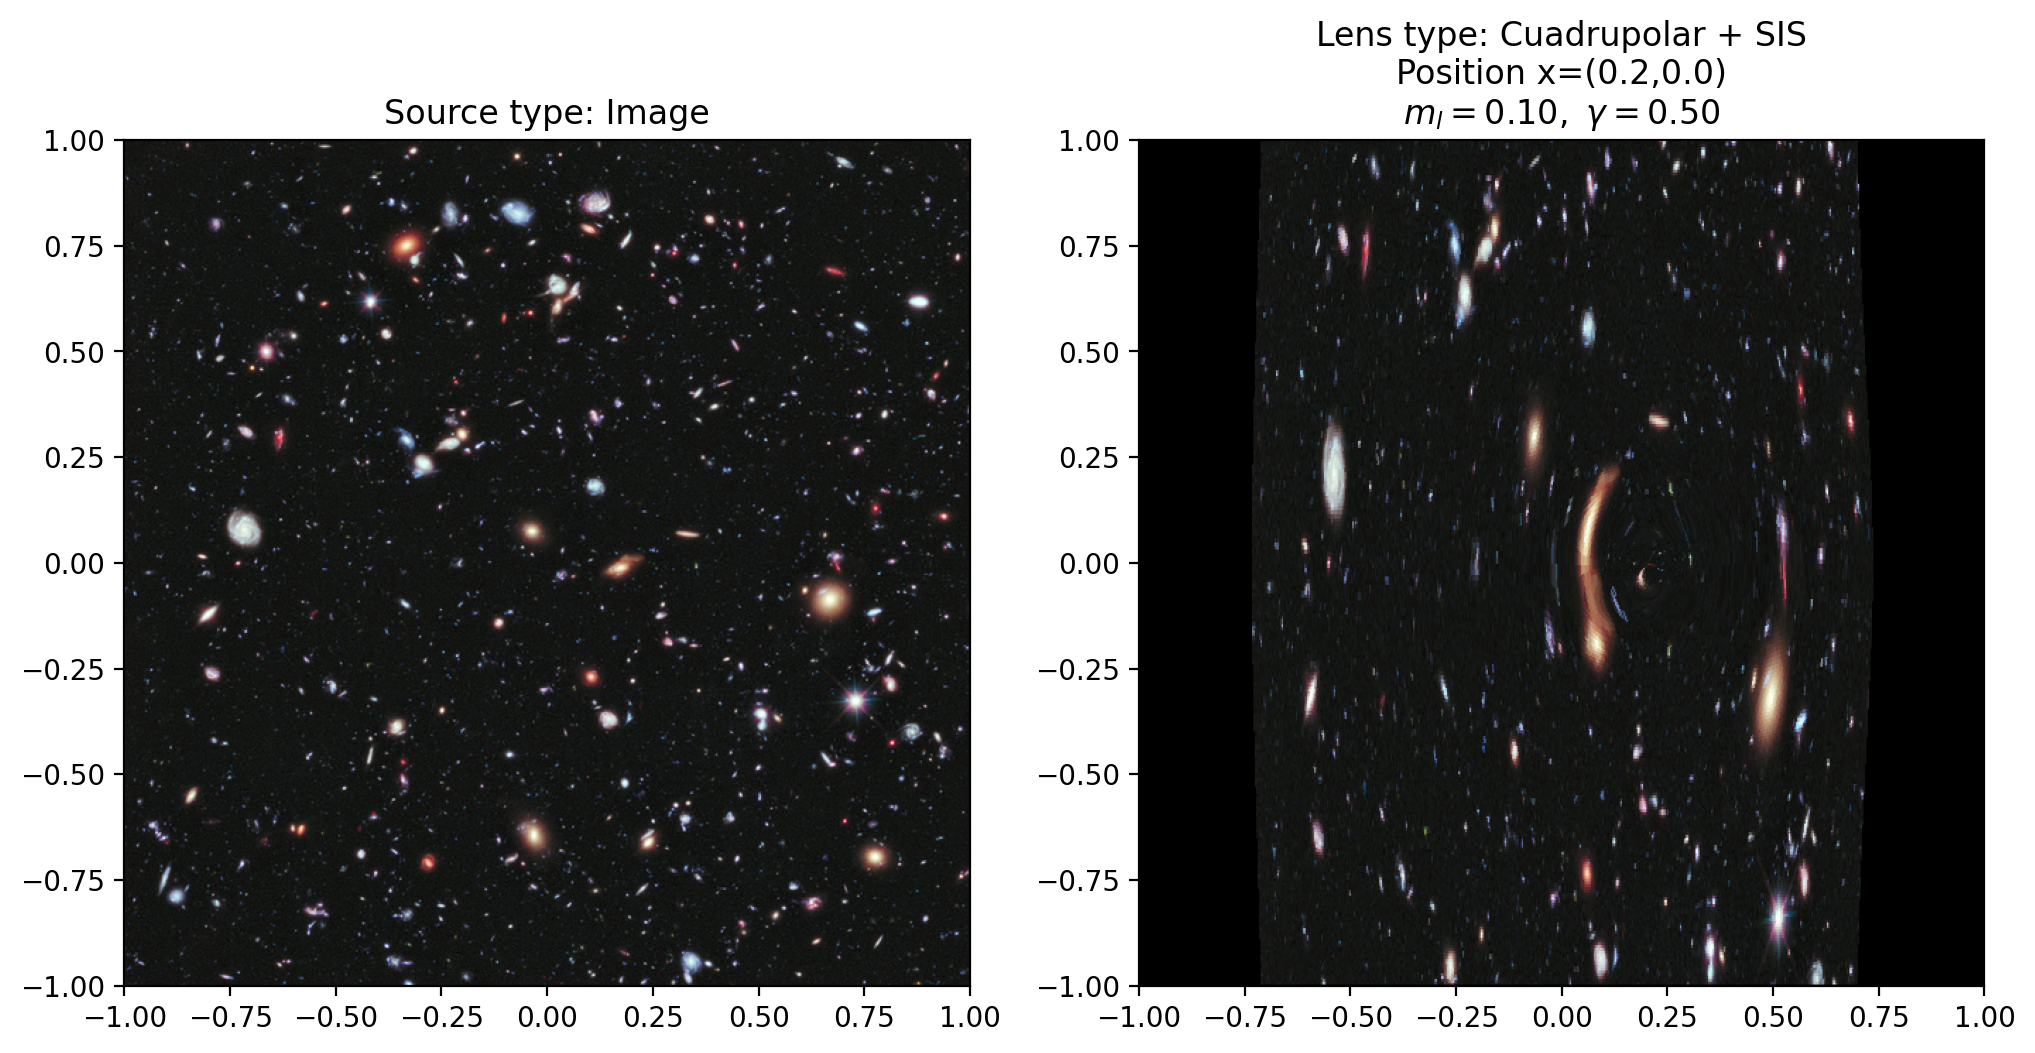

In [71]:
HDF = LG()
HDF.source_img(rgb)
gamma = 0.5
x0 = (0,.2)
HDF.transf(ploteo = True, cuadru_SIS = True, ml=0.1, x0 = x0, gam = gamma)
#HDF.transf(ploteo = True, identidad = True)

In [68]:
HDF = LG()
HDF.source_img(rgb)
for i in range(40):
    gamma = 0.1
    x0 = (0,-1+0.05*i)
    HDF.transf(ploteo = True, cuadru_SIS = True, ml=0.1, x0 = x0, gam = gamma)

    output_path = os.path.join(path, f'frames_HDF_cuadru_SIS_xs/frame_{i}.png')
    plt.savefig(output_path)
    plt.close()

In [69]:
create_animation(path+'/frames_HDF_cuadru_SIS_xs', path+'/movies', 'HDF_cuadru_SIS_xs.mp4', 8)

C:\Users\osole\AppData\Local\Temp\ipykernel_69512\692778377.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)


# Mapas de magnificación

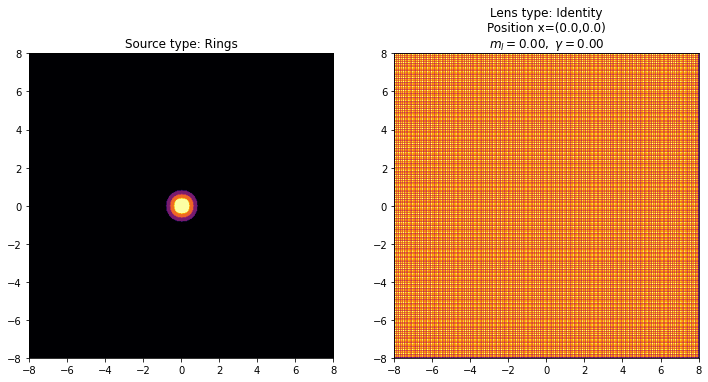

In [19]:
rin = LG()
rin.source(1, rings = True, r = 20, n_r = 3, w_r = 5)
rin.transf(ploteo = True, identidad = True, mag_map=True)

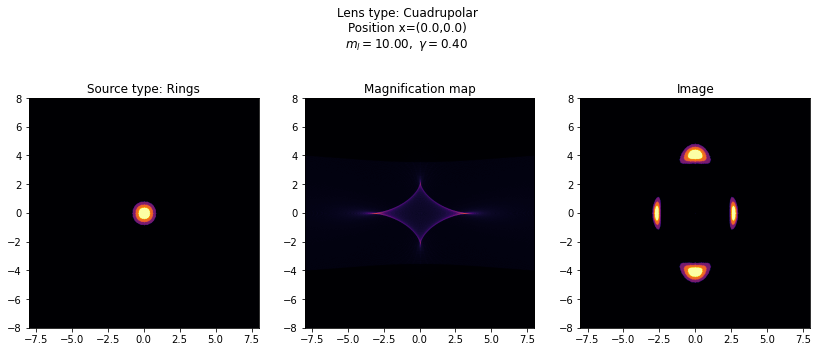

In [76]:
rin = LG(nx = 1001, ny = 388, xl = 8, yl = 8)
rin.source(1, rings = True, r = 20, n_r = 3, w_r = 5)
rin.transf(ploteo = True, cuadru = True, ml = 10, gam = 0.4, mag_map=True)

## Cortes central
Se comprueba que el cruce con una cáustica se traduce en un cambio súbito en la magnificación.

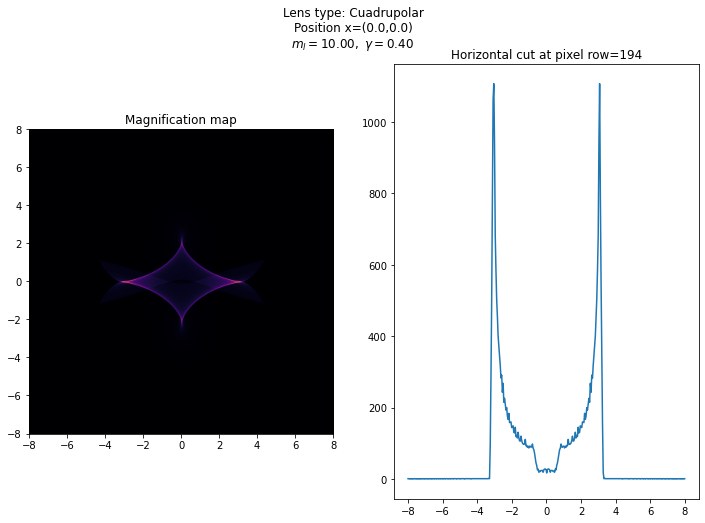

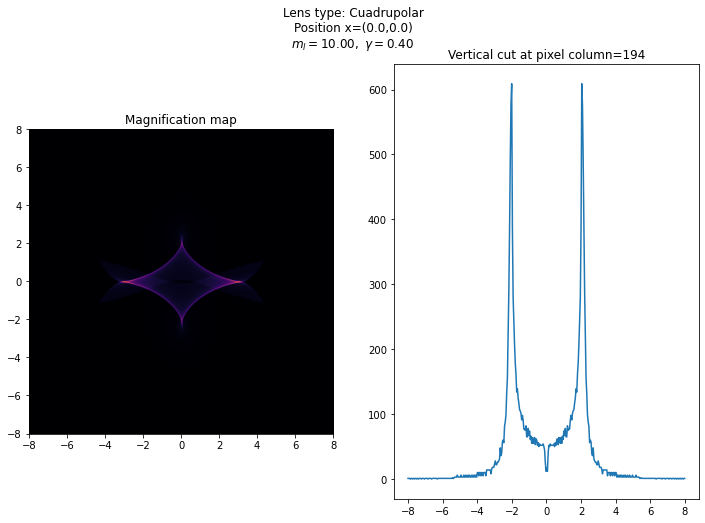

In [65]:
rin = LG(nx = 1001, ny = 388, xl = 4, yl = 8)
rin.source(1, rings = True, r = 20, n_r = 3, w_r = 5)
rin.transf(ploteo = False, cuadru = True, ml = 10, gam = 0.4, mag_map=True)
rin.map_cuts(horiz = True, nrow = 0, ploteo = True)
rin.map_cuts(vert = True, ploteo = True)

## Desplazamiento de la lente

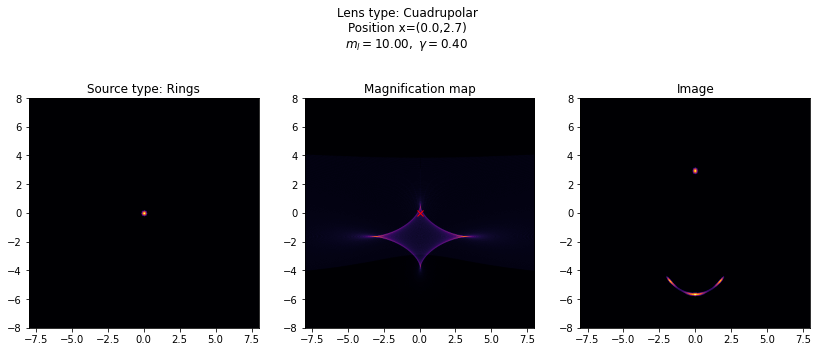

In [14]:
rin = LG(nx = 1001, ny = 388, xl = 8, yl = 8)
rin.source(1, rings = True, r = 5, n_r = 5, w_r = 1)
x0 = (2.7,0)
rin.transf(ploteo = True, cuadru = True, ml = 10, gam = 0.4,x0=x0, mag_map=True)

In [34]:
rin = LG(nx = 1001, ny = 388, xl = 8, yl = 8)
rin.source(1, rings = True, r = 5, n_r = 5, w_r = 1)
for i in range(40):
    x0 = (i*0.1,0)
    rin.transf(ploteo = True, cuadru = True, ml = 10, gam = 0.4,x0=x0, mag_map=True)
    if i<10:
        plt.savefig(f'frames_mag_map_cuadru/f_0{i}.png')
    else:
        plt.savefig(f'frames_mag_map_cuadru/f_{i}.png')
    plt.close()

In [36]:
create_animation(path+'/frames_mag_map_cuadru', path+'/movies', 'mag_map_cuadru.mp4', 8)

C:\Users\osole\AppData\Local\Temp\ipykernel_3584\692778377.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(image_path)


# Comparación con imágenes de CASTLES 2.0
http://www.cfa.harvard.edu/castles/

## H1413+117
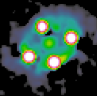

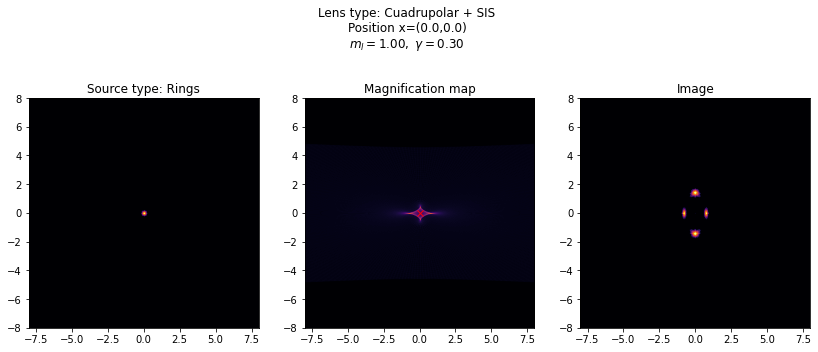

In [35]:
rin1 = LG()
rin1.source(1, rings = True, r = 5, n_r = 5, w_r = 1)

x0 = (0,0)
gamma = .3
rin1.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma, mag_map=True)

## PG1115+080
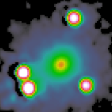 

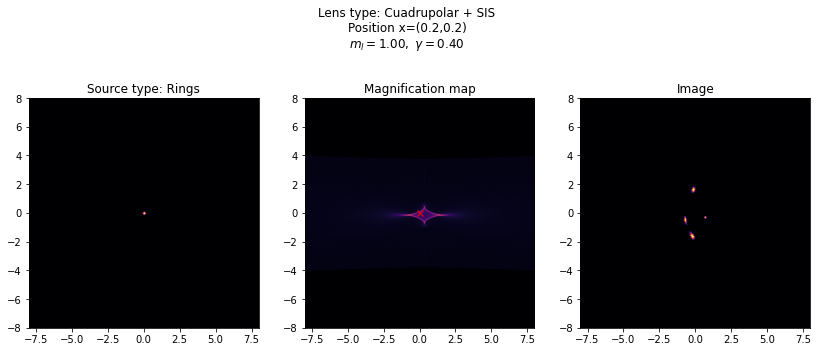

In [38]:
rin = LG()
rin.source(1, rings = True, r = 3, n_r = 3, w_r = 1)

x0 = (0.2,0.2)
gamma = .4
rin.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma, mag_map=True)

## B1422+231
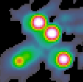

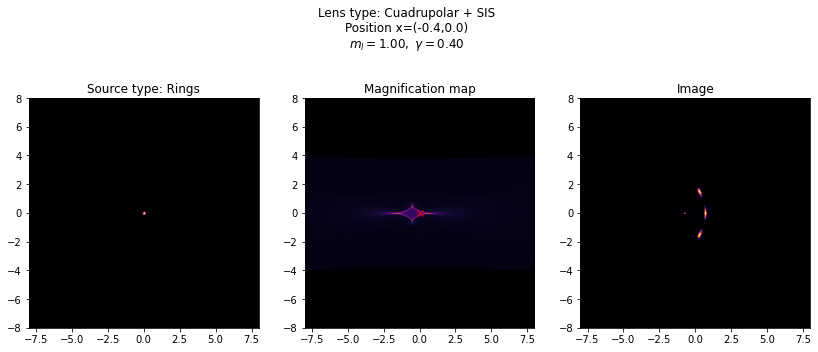

In [39]:
rin = LG()
rin.source(1, rings = True, r = 3, n_r = 3, w_r = 1)

x0 = (0,-0.4)
gamma = .4
rin.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma, mag_map=True)

## B1938+666 
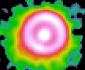

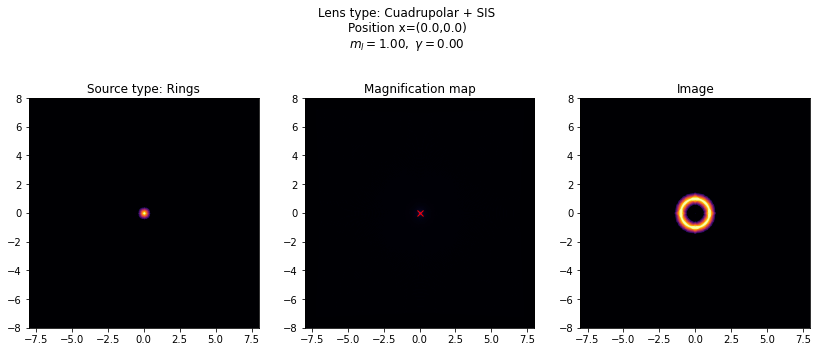

In [40]:
rin = LG()
rin.source(1, rings = True, r = 10, n_r = 5, w_r = 2)

x0 = (0,0)
gamma = 0
rin.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma, mag_map=True)

## B0631+519 
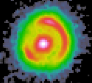

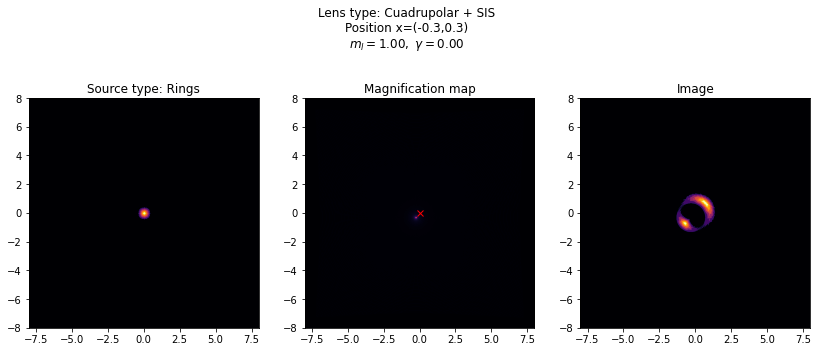

In [41]:
rin = LG()
rin.source(1, rings = True, r = 10, n_r = 5, w_r = 2)

x0 = (0.3,-0.3)
gamma = 0
rin.transf(ploteo = True, cuadru_SIS = True, ml=1, x0 = x0, gam = gamma, mag_map=True)

## SBS0909+532
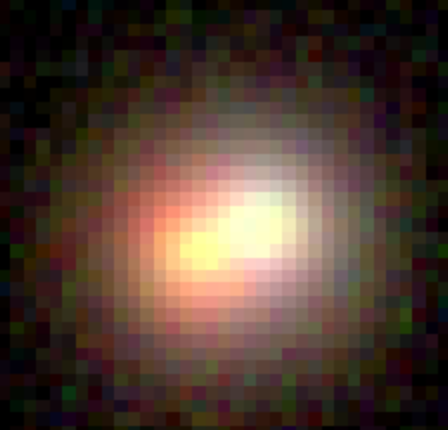

# Lentes binarias
Se cambia la ecuación de la lente por:
$$\mathbf{\alpha}=\epsilon_1 \frac{(\mathbf{x}-\mathbf{x_{d,1}})}{|\mathbf{x}-\mathbf{x_{d,1}}|^2} + \epsilon_2 \frac{(\mathbf{x}-\mathbf{x_{d,2}})}{|\mathbf{x}-\mathbf{x_{d,2}}|^2}$$

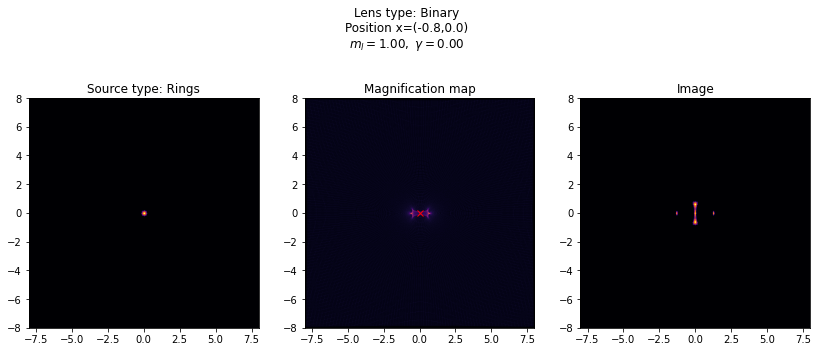

In [53]:
rin = LG()
rin.source(1, rings = True, r = 5, n_r = 5, w_r = 1)

x0 = (0,-.8)
x02 = (0,.8)
rin.transf(ploteo = True, binary = True, ml=1, x0 = x0, x02 = x02, eps1=0.5, eps2=0.5, mag_map=True)

## Reproducción de eventos de microlente binaria
A partir de la Tabla 2 de Alcock et al. 2000, ApJ, 541, 270 (https://iopscience.iop.org/article/10.1086/309393/pdf), escogiendo $\mathbf{x_{d,1}}=(-\epsilon_2 a,0)$ y $\mathbf{x_{d,2}}=(+\epsilon_1 a,0)$

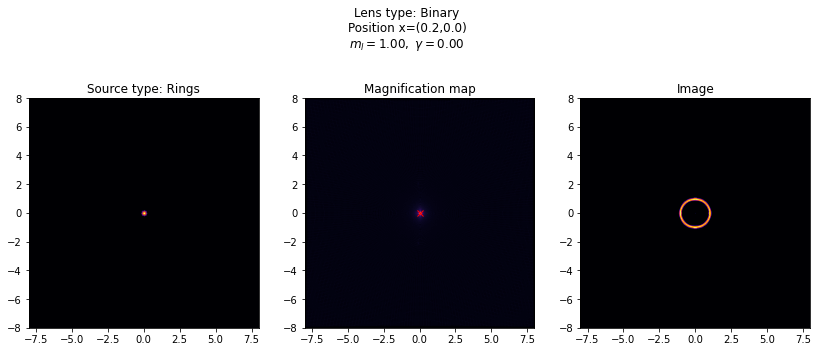

In [9]:
# LMC 1
rin = LG()
rin.source(1, rings = True, r = 5, n_r = 5, w_r = 1)
a = -0.43
m1m2 = 0.861
eps1 = m1m2/(m1m2+1)
eps2 = 1/(m1m2+1)
x0 = (0,-a*eps2)
x02 = (0,a*eps1)
rin.transf(ploteo = True, binary = True, ml=1, x0 = x0, x02 = x02, eps1=eps1, eps2=eps2, mag_map=True)
# rin.map_cuts(horiz=True, ploteo = True)

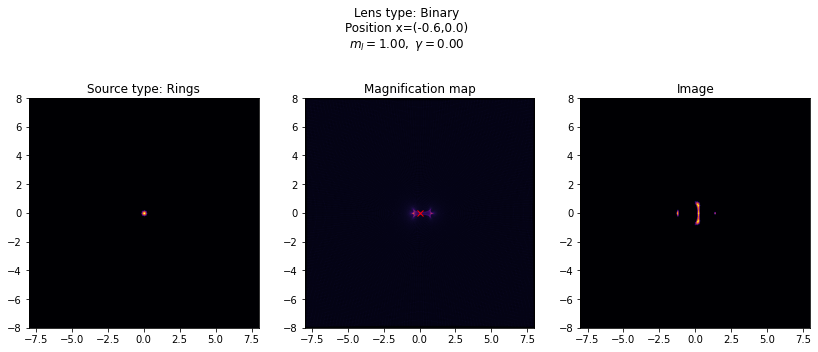

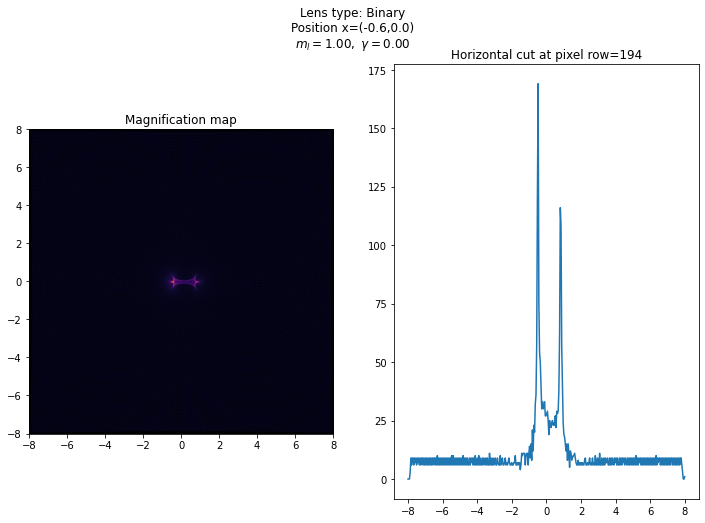

In [10]:
# LMC-9
rin = LG()
rin.source(1, rings = True, r = 5, n_r = 5, w_r = 1)
a = 1.657
m1m2 = 1.627
eps1 = m1m2/(m1m2+1)
eps2 = 1/(m1m2+1)
x0 = (0,-a*eps2)
x02 = (0,a*eps1)
rin.transf(ploteo = True, binary = True, ml=1, x0 = x0, x02 = x02, eps1=eps1, eps2=eps2, mag_map=True)
rin.map_cuts(horiz=True, ploteo = True)

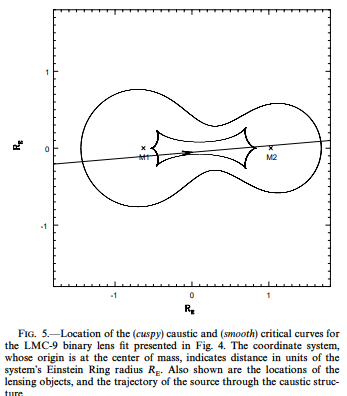 
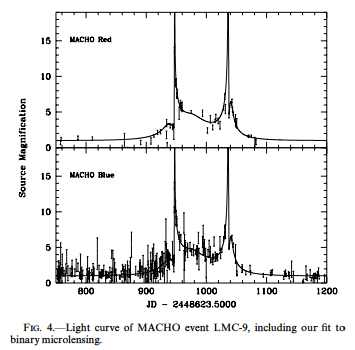

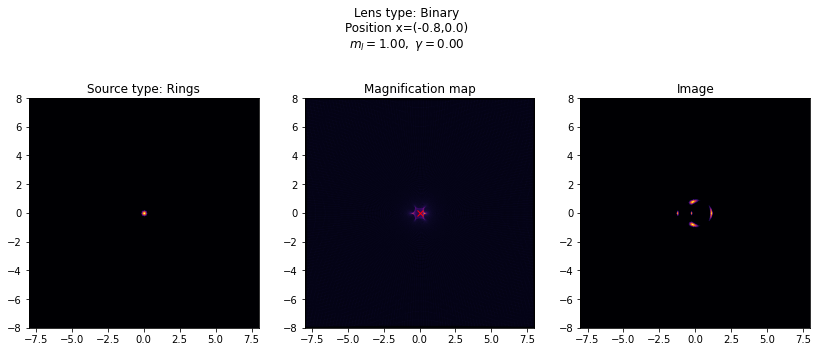

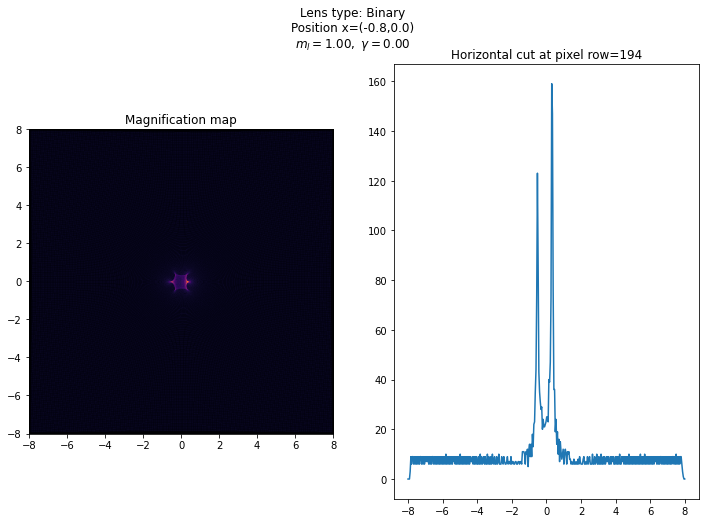

In [11]:
# 403-C
rin = LG()
rin.source(1, rings = True, r = 5, n_r = 5, w_r = 1)
a = 1.227
m1m2 = 0.556
eps1 = m1m2/(m1m2+1)
eps2 = 1/(m1m2+1)
x0 = (0,-a*eps2)
x02 = (0,a*eps1)
rin.transf(ploteo = True, binary = True, ml=1, x0 = x0, x02 = x02, eps1=eps1, eps2=eps2, mag_map=True)
rin.map_cuts(horiz=True, ploteo = True)

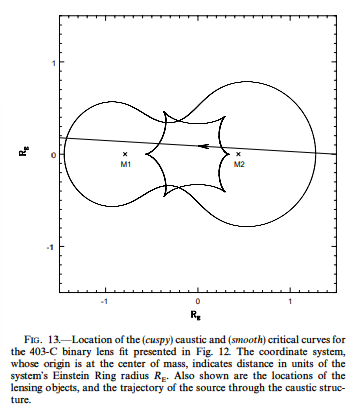
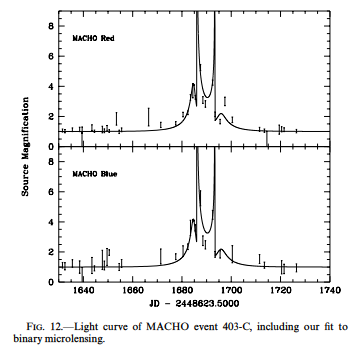